### Step 1. Import packages



In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import Regress as nsr
import math
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

from scipy import linalg
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from matplotlib import rcParams
rcParams['axes.labelsize']='x-large'
rcParams['figure.figsize']=(10,10)

#rcParams.setdefault()

In [3]:
import contextlib

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)

In [4]:
%store -r evid_list
%store -r evid_list1
%store -r evid_list2

In [5]:
len(evid_list),len(evid_list1), len(evid_list2)

(8, 10000, 10000)

### Step 2. Import data




fund_data = pd.read_excel('SmoothnessData.xlsx','Sheet1')
assets_data = pd.read_excel('SmoothnessData.xlsx','Sheet2')
#assets_data

fundstbl = fund_data.iloc[2:62,0:158].values.astype(float)
assetstbl = assets_data.iloc[2:62,0:12].values.astype(float)
dates = assets_data.iloc[2:62].index.date
fundnames = fund_data.columns.values.astype(str)
assetsall = np.mat(assetstbl)
fundsall = np.mat(fundstbl)
N, n = assetstbl

In [ ]:
fund_data_120 = pd.read_excel('Copy of Daily weekly monthly smoothness 2.xlsx','Funds daily over 60 days')
assets_data_120 = pd.read_excel('Copy of Daily weekly monthly smoothness 2.xlsx','Factors daily over 60 days')
overall_data = pd.read_excel('Copy of Daily weekly monthly smoothness 2.xlsx','Funds')
#
#

In [380]:
max_days = 60 #!!!
funds_to_test = [0, 1, 3, 5, 6, 8, 10, 12, 14, 16]
funds = fund_data_120.iloc[7:64, funds_to_test].values.astype(float)
assets = assets_data_120.iloc[2:59,:11].values.astype(float)#last one isn't in funds
assetnames = assets_data_120.columns.values[:11].astype(str)
dates = np.array([stri[:-9] for stri in fund_data_120.iloc[7:max_days+7].index.values.astype(str)])
fundnames = fund_data_120.iloc[:,funds_to_test].columns.values.astype(str)
#### Ограничения равенства
assetstbl = (assets - assets[:,0][:,np.newaxis])[:,1:]
fundstbl = funds - assets[:,0][:,np.newaxis]
####
assetsall = np.mat(funds)
fundsall = np.mat(assets)
smoothness = fund_data_120.iloc[2,funds_to_test].values.astype(float) 
turn_overs = overall_data.iloc[2].values.astype(float)[::3][funds_to_test]

In [333]:
raw_funds = fund_data_120.iloc[7:64, funds_to_test].values.astype(float)
raw_assets = assets_data_120.iloc[2:59,:11].values.astype(float)#last one isn't in funds

## Step 2.1 Evidence Step

In [80]:
def get_B(U, V):
    N, n = U.shape[0], U.shape[-1]
    B = np.zeros((N*n, N*n))
    for i in range(N):
        if i == 0:
            B[n*i:n*(i+1), n*i:n*(i+1)] = np.dot(np.dot(V[i+1].T, U[i+1]),V[i+1])
        elif i == N-1:
            B[n*i:n*(i+1), n*i:n*(i+1)] = U[i]
        else:
            B[n*i:n*(i+1), n*i:n*(i+1)] = np.dot(np.dot(V[i+1].T, U[i+1]), V[i+1]) + U[i]
        if i >= 1:
            B[n*i:n*(i+1), n*(i-1):n*i] = -U[i].dot(V[i])
            B[n*(i-1):n*i, n*i:n*(i+1)] = -(V[i].T).dot(U[i])
    return B

def get_Q(X, U, V, lam, B=None):
    N, n = U.shape[0], U.shape[-1]
    if B is None:
        B = get_B(U, V)
    return np.dot(X, X.T) + lam*B

def get_beta_min(y, X, U, V, lam, B=None):
    from scipy import linalg
    if B is None:
        B = get_B(U, V)
    return linalg.solve(get_Q(X, U, V, lam, B), np.dot(X, y))

def get_E(y, X, beta, U, V, lam, B=None):
    if B is None:
        B = get_B(U, V)
    return 0.5*(np.dot((y-np.dot(X.T, beta)).T, y-np.dot(X.T, beta)) + 
                lam*np.dot(np.dot(beta.T, B), beta))#np.sum(beta*get_B(U, V)*beta.T)) #

def log_evidence(y, X, U, V, lam, delta=None, B=None, verbose=False):
    from scipy import linalg
    N, n = U.shape[0], U.shape[-1]
    if B is None:
        B = get_B(U, V)
    beta_min = get_beta_min(y, X, U, V, lam, B)
    E = get_E(y, X, beta_min, U, V, lam, B)
    Q = get_Q(X, U, V, lam, B)
    (sign_ln_det, val_ln_det) = np.linalg.slogdet(Q)
    log_det_Q = sign_ln_det * val_ln_det
    log_D = np.sum(np.linalg.slogdet(U[1:])[0]*np.linalg.slogdet(U[1:])[1])
    #print(beta_min.shape)
    #print(E)
    if delta is None:
        const = (N*(n+1)/2-n)*(np.log(N*(n+1)-2*n)-np.log(2*np.pi)-1)
        return (N-1)*n/2*np.log(lam) -\
                (N*(n+1)/2-n)*np.log(2*E)-0.5*np.log(linalg.det(get_Q(X, U, V, lam))) + const
    const = log_D-(N-n)/2*np.log(2*np.pi)
    #B = get_B(U, V)
    #print(np.sum(np.diagonal(B) == 0))
    #print("B det ", linalg.det(B))
    if verbose: 
        print('-delta*E {:3.3}|-1/2ln(|Q|) {:3.3}|(N-1)*n/2*np.log(lam) {:3.3}| (N-n)/2*np.log(delta) {:3.3}'.format(-delta*E, 
                                                                 -0.5*log_det_Q,
                                                                 (N-1)*n/2*np.log(lam), (N-n)/2*np.log(delta)))
    
    if np.any(sign_ln_det == -1):
        raise RuntimeError("Determinant bad sign: ", sign_ln_det)
    return (N-1)*n/2*np.log(lam) + (N-n)/2*np.log(delta)\
            - 0.5*log_det_Q - delta*E + const

In [99]:
N, n = assetstbl.shape
U = np.zeros((N, n, n))
V = np.zeros((N, n, n))
for i in range(1, N):
    U[i] = np.eye(n)
    V[i] = np.eye(n)
X = np.zeros((N*n, N))
for i in range(N):
    X[n*i:n*(i+1), i] = assetstbl[i]

B = get_B(U, V)

lam_arr = np.logspace(0.1, 10, num=20, base=2)
delta_arr = np.logspace(0.1, 10, num=20, base=2)
lamv, deltav = np.meshgrid(lam_arr, delta_arr)
evid_arr = np.empty_like(lamv)

for i in range(evid_arr.shape[0]):
    for j in range(evid_arr.shape[1]):
        evid_arr1[i, j] = log_evidence(y, X_ev, U, V, lamv[i, j], deltav[i, j]) # evid_arr[i, j] = 

### print it
fig = plt.figure()
ax = plt.gca()
ax.set_xlabel(r'$\lambda$')
ax.set_xticklabels(np.round(lam_arr, decimals=3), rotation=45)
ax.set_ylabel(r'$\delta$')
ax.set_yticklabels(np.round(delta_arr, decimals=3), rotation=45)
im = ax.imshow(evid_arr, interpolation='none')
plt.colorbar(im)
### show it
with printoptions(precision=2, linewidth=1000, suppress=True):
    print(evid_arr)

<IPython.core.display.Javascript object>


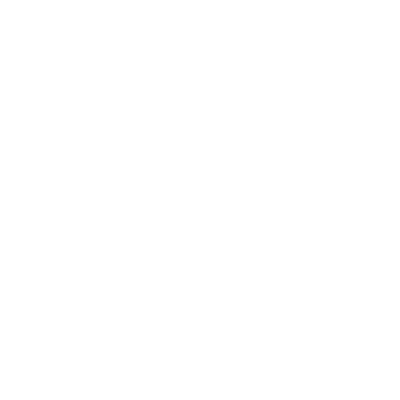

In [492]:
fig = plt.figure(figsize=(5, 5))
ax = fig.gca(projection='3d')

ax.plot_surface(deltav, lamv, evid_arr, rstride=8, cstride=8, alpha=0.3)
cset = ax.contour(deltav, lamv, evid_arr, zdir='z', offset=np.min(evid_arr), cmap=cm.coolwarm)
cset = ax.contour(deltav, lamv, evid_arr, zdir='x', offset=np.min(delta_arr), cmap=cm.coolwarm)
cset = ax.contour(deltav, lamv, evid_arr, zdir='y', offset=np.min(lam_arr), cmap=cm.coolwarm)

ax.set_xlim(np.min(delta_arr), np.max(delta_arr))
ax.set_xlabel('delta')
ax.set_ylim(np.min(lam_arr), np.max(lam_arr))
ax.set_ylabel('lambda')
ax.set_zlim(np.min(evid_arr), np.max(evid_arr))
ax.set_zlabel('evidence')

ax.xaxis.set_scale('log')
ax.yaxis.set_scale('log')

## Step 2.2.0 Сверточный байесовский вывод

In [13]:
from scipy import optimize as opt

In [19]:
N, n = assetstbl.shape
X_ev = np.zeros((N*n, N))
for i in range(N):
    X_ev[n*i:n*(i+1), i] = assetstbl[i]
# print(X_ev)
# y_ev = np.repeat(fundstbl, n, axis=0).T
# print(y_ev)
y = fundstbl[:,0]
U = np.zeros((N, n, n))
V = np.zeros((N, n, n))
for i in range(1, N):
    U[i] = np.eye(n)
    V[i] = np.eye(n)
    
B = get_B(U, V)

In [64]:
np.linalg.eigvals(get_Q(X_ev, U, V, 0.8, B))

array([  4.92410106e+01,   3.85649632e+01,   3.20269100e+01,
         3.09640067e+01,   2.68932603e+01,   2.66602727e+01,
         3.02260879e+01,   2.30924249e+01,   3.01384325e+01,
         2.40592535e+01,   2.22543909e+01,   2.05436031e+01,
         2.82268483e+01,   1.70695983e+01,   2.56798416e+01,
         1.47956515e+01,   2.09285789e+01,   1.32635694e+01,
         1.68164107e+01,   1.61075159e+01,   1.34640861e+01,
         1.56629609e+01,   1.08079985e+01,   1.15662647e+01,
         1.22094972e+01,   1.15108011e+01,   9.37353061e+00,
         1.15808940e+01,   1.10275445e+01,   9.83749631e+00,
         9.25521606e+00,   9.07559908e+00,   8.50825318e+00,
         1.12208311e+01,   9.55781277e+00,   8.64889692e+00,
         6.58498596e+00,   7.98735028e+00,   6.26196782e+00,
         7.10313940e+00,   6.84012755e+00,   6.14782403e+00,
         5.96989588e+00,   5.68170089e+00,   5.28462988e+00,
         4.93767214e+00,   5.25490852e+00,   4.98128260e+00,
         5.03851859e+00,

In [79]:
def p_conv(lam_del, y, X, U, V, B=None, N=N, n=n):
    # N, n = y.shape[0], X.shape[0]/y.shape[0]
    lam,delta = lam_del
    Mat = np.eye(N) - np.dot(X.T, np.dot(np.linalg.inv(get_Q(X, U, V, lam, B)), X))
    #print(np.linalg.eigvals(Mat))
    log_det = np.linalg.slogdet(Mat)
    return N/2*delta - N/2*np.log(2*np.pi)+1/2*log_det[0]*log_det[1] - delta/2*np.dot(np.dot(y.T, Mat), y)

In [80]:
p_conv(np.array([0.8, 1]), y, X_ev, U, V, B)

257.84491501653099

In [89]:
Mat = np.eye(N) - np.dot(X_ev.T, np.dot(np.linalg.inv(get_Q(X_ev, U, V, 0.8, B)), X_ev))
print(np.linalg.eigvals(Mat))

[  2.85197648e-01 +0.00000000e+00j   2.14324473e-01 +0.00000000e+00j
   1.66393903e-01 +0.00000000e+00j   1.57410651e-01 +0.00000000e+00j
   1.44621760e-01 +0.00000000e+00j   1.34025130e-01 +0.00000000e+00j
   1.19706730e-01 +0.00000000e+00j   1.12296012e-01 +0.00000000e+00j
   1.08601806e-01 +0.00000000e+00j   1.04056384e-01 +0.00000000e+00j
   8.40616856e-02 +0.00000000e+00j   8.10923485e-02 +0.00000000e+00j
   7.92820641e-02 +0.00000000e+00j   7.75588575e-02 +0.00000000e+00j
   6.74157123e-02 +0.00000000e+00j   6.39406540e-02 +0.00000000e+00j
   5.86122706e-02 +0.00000000e+00j   5.46780688e-02 +0.00000000e+00j
   5.16008726e-02 +0.00000000e+00j   5.03779258e-02 +0.00000000e+00j
   4.81417829e-02 +0.00000000e+00j   4.19938852e-02 +0.00000000e+00j
   3.65612612e-02 +0.00000000e+00j   3.45267385e-02 +0.00000000e+00j
   3.16559862e-02 +0.00000000e+00j   3.20907972e-02 +0.00000000e+00j
   2.75222129e-02 +0.00000000e+00j   2.19854908e-02 +0.00000000e+00j
   2.06899129e-02 +0.00000000e+00j

In [81]:
def  p_conv_prime(lam_del, y, X, U, V, B=None, N=N, n=n):
    res = np.array([0, 0])
    lam, delta = lam_del
    Q_1 = np.linalg.inv(get_Q(X, U, V, lam, B))
    Mat = np.eye(N) - np.dot(X.T, np.dot(Q_1, X))
    res[1] = N/2 - 1/2*np.dot(y.T, np.dot(Mat, y))
    Mat1 = np.dot(X.T, np.dot(Q_1, np.dot(B, np.dot(Q_1, X))))
    res[0] = 1/2*np.trace(np.dot(np.linalg.inv(Mat), Mat1))-delta/2*np.dot(y.T, np.dot(Mat1, y))
    return res

In [82]:
p_conv_prime(np.array([0.8, 1]), y, X_ev, U, V, B)

array([28, 29])

In [85]:
def check(p_conv, p_conv_prime, x0, y, X, U, V, B=None):
    eps = np.sqrt(np.finfo(float).eps)
    lam_del1 = np.array([x0[0]+eps, x0[1]])
    lam_del2 = np.array([x0[0], x0[1]+eps])
    val = p_conv(x0, y, X, U, V, B)
    val1 = p_conv(lam_del1, y, X, U, V, B)
    val2 = p_conv(lam_del2, y, X, U, V, B)
    return np.array([val1 - val,val2 - val])/eps, p_conv_prime(x0, y, X, U, V, B)

In [90]:
check(p_conv, p_conv_prime, np.array([0.7, 1]),y, X_ev, U, V, B)

(array([ -3.83989123e+10,   2.99733658e+01]), array([32, 29]))

## Step 2.2 Итеративный алгоритм

In [182]:
import time
fl = 1
lam = 0.1
delta = 0.1
beta_min = get_beta_min(y, X_ev, U, V, lam)
evid_list = [log_evidence(y, X_ev, U, V, lam, delta)]
lam_list = [lam]
delta_list = [delta]
B = get_B(U, V)
#cnt = 0
tm = time.time()
cur_tm = tm
while(fl):
    #cnt +=1 
    s_lam = np.trace(np.dot(np.linalg.inv(get_Q(X_ev, U, V, lam)),B))
    lam = (N-1)*n/(s_lam + delta*np.dot(np.dot(beta_min.T, B), beta_min))
    beta_min = get_beta_min(y, X_ev, U, V, lam, B)
    lam_list += [lam]
    delta = (N-n)/(2*get_E(y, X_ev, beta_min, U, V, lam, B))
    evid_list += [log_evidence(y, X_ev, U, V, lam, delta, B)]
    delta_list += [delta]
    if np.allclose(evid_list[-1], evid_list[-2], rtol=0, atol=1e-5):
        break
    #print(time.time()-tm)
    cur_tm = time.time() - tm

KeyboardInterrupt: 

In [199]:
 np.any(np.isnan(evid_arr))

True

In [198]:
#with printoptions(precision=6):
#    print(np.diff(np.array(evid_list)))
len(evid_list), evid_list[-1], np.any(np.diff(np.array(evid_list)) < 0), np.any(np.isnan(evid_arr)), np.any(evid_arr > 0)

(8080, 4.3407288041239056, False, True, True)

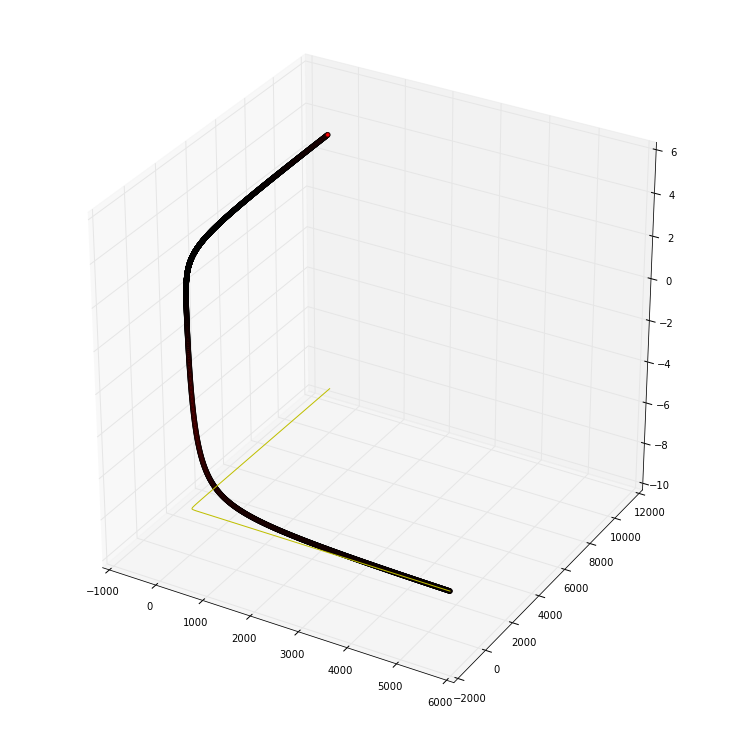

In [192]:
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)
#ax.plot(delta_list[1::2], lam_list[1::2], evid_list[1::2])
ax.scatter(delta_list[1::2], lam_list[1::2], evid_list[1::2], c='r')
ax.plot(delta_list[1::2], lam_list[1::2], min(evid_list[1::2]), c='y', lw=1)

In [204]:
delta_list[-1]

34.591104054371307

In [206]:
lam_arr = lam_list[-1] + lam_list[-1]*np.append(-np.logspace(-5, -1, num=nn, base=2)[::-1], 
                                   np.logspace(-5, -1, num=nn, base=2))#np.linspace(-1, 1, num=20)/100
delta_arr = delta_list[-1] + delta_list[-1]*np.append(-np.logspace(-5, 0, num=nn, base=2)[::-1], 
                                       np.logspace(-5, -1, num=nn, base=2))
np.any(lam_arr < 0), np.any(delta_arr < 0)

(False, False)

In [212]:
nn = 20
lam_arr = lam_list[-1] + lam_list[-1]*np.append(-np.logspace(-5, -0.1, num=nn, base=2)[::-1], 
                                   np.logspace(-5, -1, num=nn, base=2))#np.linspace(-1, 1, num=20)/100
delta_arr = delta_list[-1] + delta_list[-1]*np.append(-np.logspace(-5, -0.1, num=nn, base=2)[::-1], 
                                       np.logspace(-5, -1, num=nn, base=2))
#np.logspace(0.1, 10, num=20, base=2)
lamv, deltav = np.meshgrid(lam_arr, delta_arr)
evid_arr = np.empty_like(lamv)
for i in range(evid_arr.shape[0]):
    for j in range(evid_arr.shape[1]):
        evid_arr[i, j] = log_evidence(y, X_ev, U, V, lamv[i, j], deltav[i, j]) # evid_arr[i, j] = 
np.any(np.isnan(evid_arr)), np.any(evid_arr > 0)

(False, True)

In [195]:
lamv.shape, deltav.shape, evid_arr.shape

((40, 40), (40, 40), (40, 40))

In [218]:
lam_list[1:500]

[0.1072113223023244,
 0.10726839372156845,
 0.10732552418343999,
 0.10738271377785683,
 0.10743996259491131,
 0.10749727072488688,
 0.1075546382581813,
 0.10761206528535432,
 0.10766955189728461,
 0.10772709818490596,
 0.10778470423939356,
 0.10784237015210683,
 0.10790009601446524,
 0.10795788191833378,
 0.10801572795545218,
 0.10807363421799417,
 0.10813160079816676,
 0.10818962778845641,
 0.10824771528145578,
 0.10830586337005074,
 0.10836407214720656,
 0.10842234170610894,
 0.10848067214011524,
 0.10853906354281352,
 0.10859751600803451,
 0.10865602962961912,
 0.10871460450178937,
 0.1087732407188301,
 0.10883193837526678,
 0.10889069756583415,
 0.10894951838545046,
 0.10900840092911893,
 0.10906734529225581,
 0.1091263515702183,
 0.10918541985881045,
 0.10924455025382707,
 0.10930374285137458,
 0.10936299774759813,
 0.10942231503912594,
 0.1094816948224996,
 0.10954113719457308,
 0.10960064225239745,
 0.10966021009323372,
 0.10971984081451672,
 0.10977953451394099,
 0.109839291289

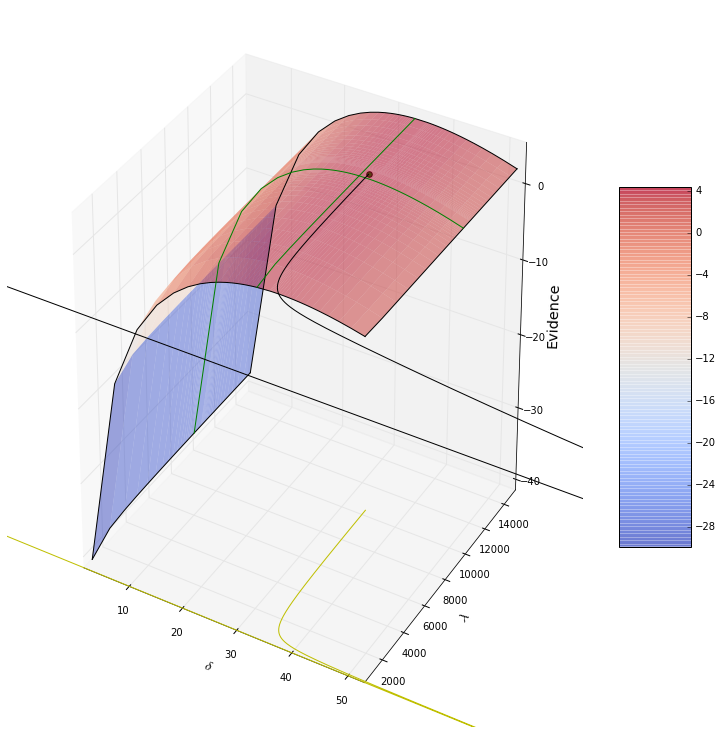

In [213]:
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)

nn = (lam_arr.size-1)//2
surf = ax.plot_surface(deltav, lamv, evid_arr, rstride=1, cstride=1,  cmap=cm.coolwarm,
                       linewidth=0, alpha=0.5)
fig.colorbar(surf, shrink=0.5, aspect=5)
#ax.plot_surface(deltav, lamv, evid_arr, rstride=5, cstride=5)
#ax.scatter(deltav, lamv, evid_arr)
#cset = ax.contour(deltav, lamv, evid_arr, zdir='z', offset=np.min(evid_arr), cmap=cm.coolwarm)
#cset = ax.contour(deltav, lamv, evid_arr, zdir='x', offset=np.min(delta_arr), cmap=cm.coolwarm)
#cset = ax.contour(deltav, lamv, evid_arr, zdir='y', offset=np.min(lam_arr), cmap=cm.coolwarm)
#borders
ax.plot(delta_arr[0]*np.ones((delta_arr.size, 1)), lamv[0, :], evid_arr[0, :], c='k', lw=1)
ax.plot(delta_arr[-1]*np.ones((delta_arr.size, 1)), lamv[-1, :], evid_arr[-1, :], c='k', lw=1)
ax.plot(deltav[:, 0], lam_arr[0]*np.ones((lam_arr.size, 1)),  evid_arr[:, 0], c='k', lw=1)
ax.plot(deltav[:, -1], lam_arr[-1]*np.ones((lam_arr.size, 1)),  evid_arr[:, -1], c='k', lw=1)
#opt
ax.scatter(delta_list[-1], lam_list[-1], evid_list[-1], s=30, c='g')# opt
ax.plot(delta_arr[nn]*np.ones((delta_arr.size, 1)), lamv[nn, :], evid_arr[nn, :], c='g', lw=1)
ax.plot(deltav[:, nn], lam_arr[nn]*np.ones((lam_arr.size, 1)),  evid_arr[:, nn], c='g', lw=1)


ax.set_xlim(np.min(delta_arr), np.max(delta_arr))
ax.set_xlabel('$\delta$')
ax.set_ylim(np.min(lam_arr), np.max(lam_arr))
ax.set_ylabel('$\lambda$')
ax.set_zlim(np.min(evid_arr), np.max(evid_arr))
ax.set_zlabel('Evidence')

ax.plot(delta_list[1::2], lam_list[1::2], evid_list[1::2], c='k', lw=1)
ax.plot(delta_list[1::2], lam_list[1::2], np.min(evid_arr), c='y', lw=1)

#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_zscale('log')

In [71]:
delta_list[-1]

3801.5921091459359

In [95]:
def iterate_log_evidence(evid_list, lam_list, delta_list, y, X_ev, U, V):
    import time
    fl = 1
    lam = 0.1
    delta = 0.1
    beta_min = get_beta_min(y, X_ev, U, V, lam)
    B = get_B(U, V)
    cnt = 0
    tm = time.time()
    cur_tm = tm
    while(fl):
        cnt +=1 
        ## beta -> m_N, gamma -> 
        #
        s_lam = np.trace(np.dot(np.linalg.inv(get_Q(X_ev, U, V, lam)),B))
        #alpha
        lam = (N-1)*n/(s_lam + delta*np.dot(np.dot(beta_min.T, B), beta_min))
        #m_N
        beta_min = get_beta_min(y, X_ev, U, V, lam, B)
        lam_list += [lam]
        ## beta
        delta = (N-n)/(2*get_E(y, X_ev, beta_min, U, V, lam, B))
        #evid
        evid_list += [log_evidence(y, X_ev, U, V, lam, delta, B)]
        delta_list += [delta]
        if cnt != 1 and np.allclose(evid_list_full[-1], evid_list_full[-2], rtol=0, atol=1e-6) or cnt >= 10000 :
            break
        #print(time.time()-tm)
        cur_tm = time.time() - tm
        

In [317]:
evid_list1 = []
lam_list1 = []
delta_list1 = []
iterate_log_evidence(evid_list1, lam_list1, delta_list1, fundstbl[:, 1], X_ev, U, V)

In [318]:
delta_list1[-1], np.any(np.array(delta_list1) < 0), lam_list1[-1], np.any(np.array(lam_list1) < 0)

(11.429934171445094, False, 27414.800561328768, False)

In [320]:
len(evid_list1)

10000

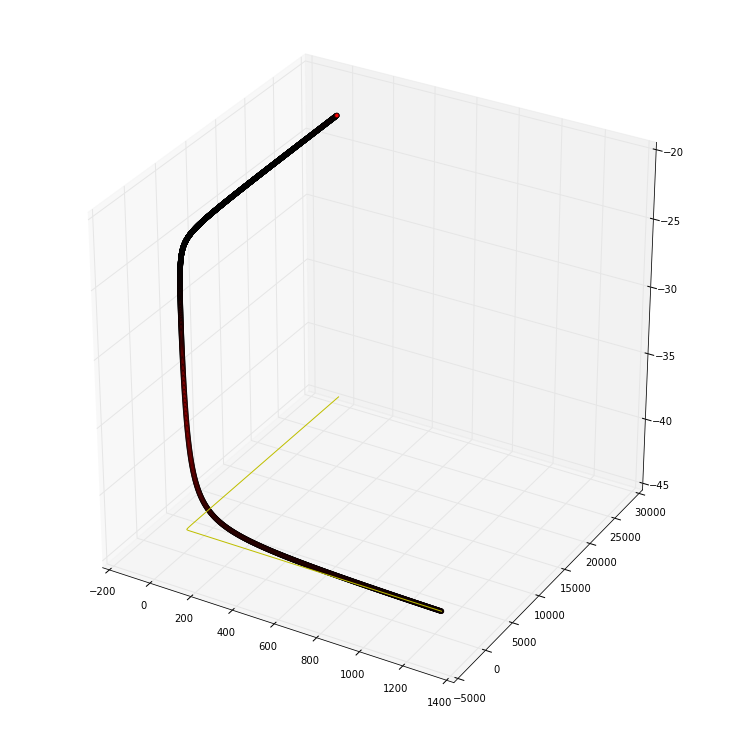

In [319]:
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)
#ax.plot(delta_list[1::2], lam_list[1::2], evid_list[1::2])
ax.scatter(delta_list1[::2], lam_list1[::2], evid_list1[::2], c='r')
ax.plot(delta_list1[::2], lam_list1[::2], min(evid_list1[::2]), c='y', lw=1)

In [304]:
evid_list2 = []
lam_list2 = []
delta_list2 = []
iterate_log_evidence(evid_list2, lam_list2, delta_list2, fundstbl[:, 2], X_ev, U, V)

In [316]:
delta_list2[-1], np.any(np.array(delta_list2) < 0), lam_list2[-1], np.any(np.array(lam_list2) < 0)

(85.993948238477472, False, 14216.684551013299, False)

In [305]:
len(evid_list2)

10000

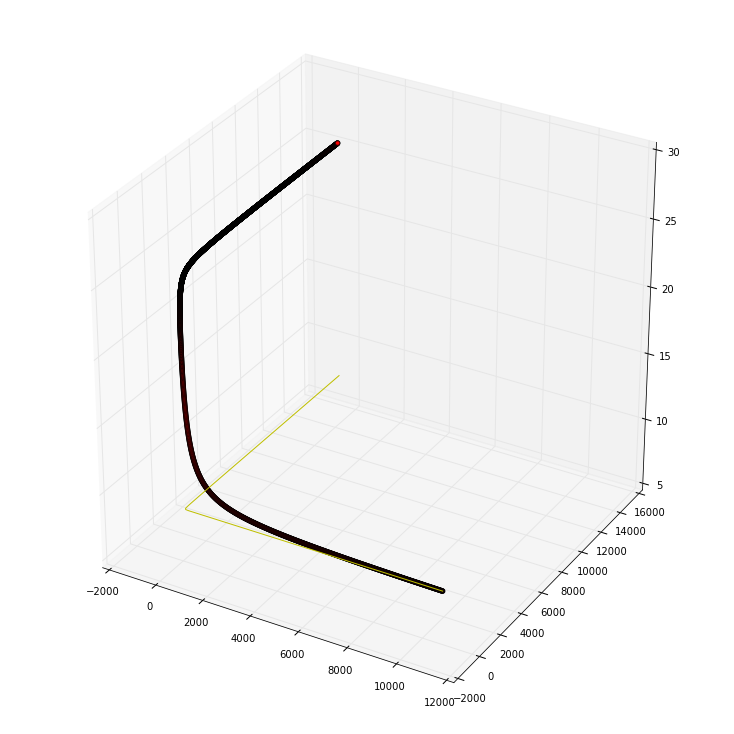

In [308]:
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)
#ax.plot(delta_list[1::2], lam_list[1::2], evid_list[1::2])
ax.scatter(delta_list2[::2], lam_list2[::2], evid_list2[::2], c='r')
ax.plot(delta_list2[::2], lam_list2[::2], min(evid_list2[::2]), c='y', lw=1)

In [262]:
ind = np.diff(np.isclose(evid_list_full[:-1], evid_list_full[1:], rtol=0, atol=1e-5))
ind = np.where(ind)[0]

In [253]:
lam_list_full[-1], delta_list_full[-1], len(lam_list_full)

(31695.330776042611, 34.440004865965918, 15369)

In [275]:
evid_list_full[ind[0]+1]

4.3850149145600383

In [277]:
np.sum(np.diff(np.diff(evid_list_full)) < 0)

8799

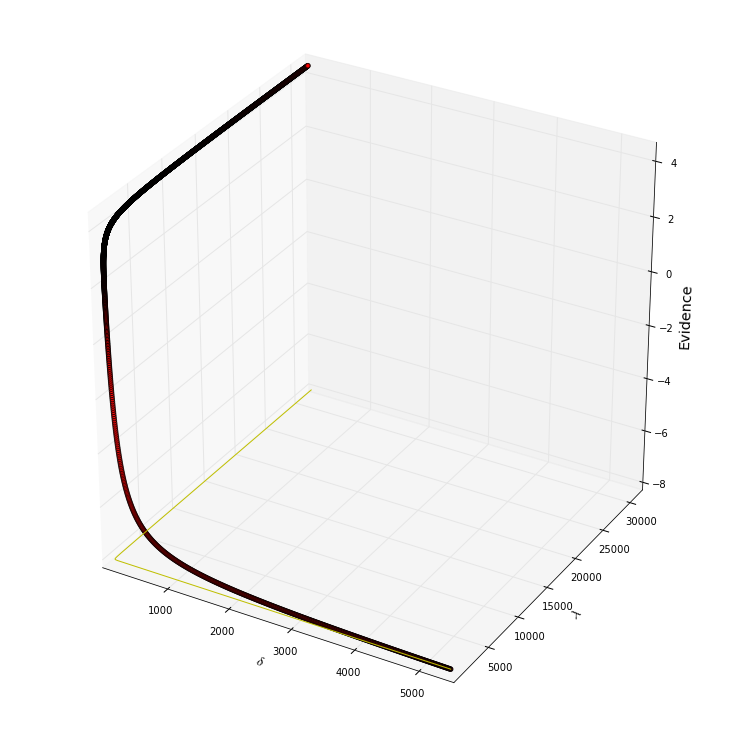

In [272]:
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)
#ax.plot(delta_list[1::2], lam_list[1::2], evid_list[1::2])
ax.scatter(delta_list_full[::4], lam_list_full[::4], evid_list_full[::4], c='r')
ax.plot(delta_list_full[::4], lam_list_full[::4], min(evid_list_full[::4]), c='y', lw=1)
ax.set_xlim(np.min(delta_list_full), np.max(delta_list_full))
ax.set_xlabel('$\delta$')
ax.set_ylim(np.min(lam_list_full), np.max(lam_list_full))
ax.set_ylabel('$\lambda$')
ax.set_zlim(np.min(evid_list_full), np.max(evid_list_full))
ax.set_zlabel('Evidence')

In [270]:
len(evid_list_full), ind[0]

(15367, 10718)

In [273]:
evid_list_full[ind[0]], evid_list_full[-2:]

(4.385004851984327, [4.4123182932689318, 4.412321791325617])

In [274]:
lam_list_full[-1], delta_list_full[-1]

(31695.330776042611, 34.440004865965918)

In [209]:
def iterate_log_evidence(evid_list, lam_list, delta_list, y, X_ev, U, V, lam=None, delta=None):
    import time
    fl = 1
    lam = 0.1 if lam is None else lam
    delta = 0.1 if delta is None else delta
    beta_min = get_beta_min(y, X_ev, U, V, lam)
    B = get_B(U, V)
    cnt = 0
    tm = time.time()
    cur_tm = tm
    while(fl):
        cnt +=1 
        ## beta -> m_N, gamma -> 
        #
        s_lam = np.trace(np.dot(np.linalg.inv(get_Q(X_ev, U, V, lam)),B))
        #alpha
        lam = (N-1)*n/(s_lam + delta*np.dot(np.dot(beta_min.T, B), beta_min))
        #m_N
        beta_min = get_beta_min(y, X_ev, U, V, lam, B)
        lam_list += [lam]
        ## beta
        delta = (N-n)/(2*get_E(y, X_ev, beta_min, U, V, lam, B))
        #evid
        evid_list += [log_evidence(y, X_ev, U, V, lam, delta, B)]
        delta_list += [delta]
        if (cnt != 1 and (np.allclose(evid_list[-1], evid_list[-2], rtol=0, atol=1e-6) or
        np.allclose(lam_list[-1], lam_list[-2], rtol=0, atol=1e-8) and np.allclose(delta_list[-1], delta_list[-2], rtol=0, atol=1e-8 ))
                         or cnt >= 10000) :
            break
        #print(time.time()-tm)
        cur_tm = time.time() - tm

In [240]:
# tmpstmp = []
# evid_list_full = []
# lam_list_full = []
# delta_list_full = []
import time
#for i in range(1):
tm = time.time()
# evid_list = []
# lam_list = []
# delta_list = []
evid_list = []
lam_list = []
delta_list = []
y = fundstbl[:, 6]
iterate_log_evidence(evid_list, lam_list, delta_list, y, X, U, V)
# evid_list_full += [evid_list]
# lam_list_full += [lam_list]
# delta_list_full += [delta_list]
#print("Fund number {0}, time {1}", i,time.time() - tm)
# tmpstmp += [time.time() - tm]

In [217]:
evid_list_full += [evid_list]
lam_list_full += [lam_list]
delta_list_full += [delta_list]

In [245]:
%store evid_list_full
%store lam_list_full
%store delta_list_full

Stored 'evid_list_full' (list)
Stored 'lam_list_full' (list)
Stored 'delta_list_full' (list)


In [296]:
evid_list_full[5] = evid_list5
lam_list_full[5] = lam_list5
delta_list_full[5] = delta_list5

In [297]:
evid_list_full[5]

[8.9503969292892691,
 8.9504638588612409,
 8.9505308521292761,
 8.9505979091811412,
 8.9506650301085244,
 8.9507322150013522,
 8.9507994639511992,
 8.9508667770471959,
 8.9509341543813719,
 8.9510015960461544,
 8.9510691021298214,
 8.9511366727267898,
 8.9512043079269858,
 8.9512720078222117,
 8.9513397725056905,
 8.9514076020695654,
 8.9514754966045018,
 8.9515434562046892,
 8.9516114809622138,
 8.9516795709696737,
 8.9517477263209742,
 8.9518159471093952,
 8.9518842334270232,
 8.9519525853682751,
 8.9520210030274541,
 8.9520894864976697,
 8.9521580358735662,
 8.9522266512496174,
 8.9522953327197285,
 8.9523640803776914,
 8.952432894321106,
 8.9525017746418882,
 8.9525707214376382,
 8.9526397348024318,
 8.9527088148320502,
 8.9527779616228997,
 8.9528471752703638,
 8.9529164558697687,
 8.9529858035179188,
 8.9530552183129828,
 8.9531247003496048,
 8.9531942497249304,
 8.9532638665372986,
 8.9533335508819789,
 8.9534033028573106,
 8.9534731225612916,
 8.953543010091181,
 8.953612965544

In [295]:
%store -r evid_list5
%store -r lam_list5
%store -r delta_list5

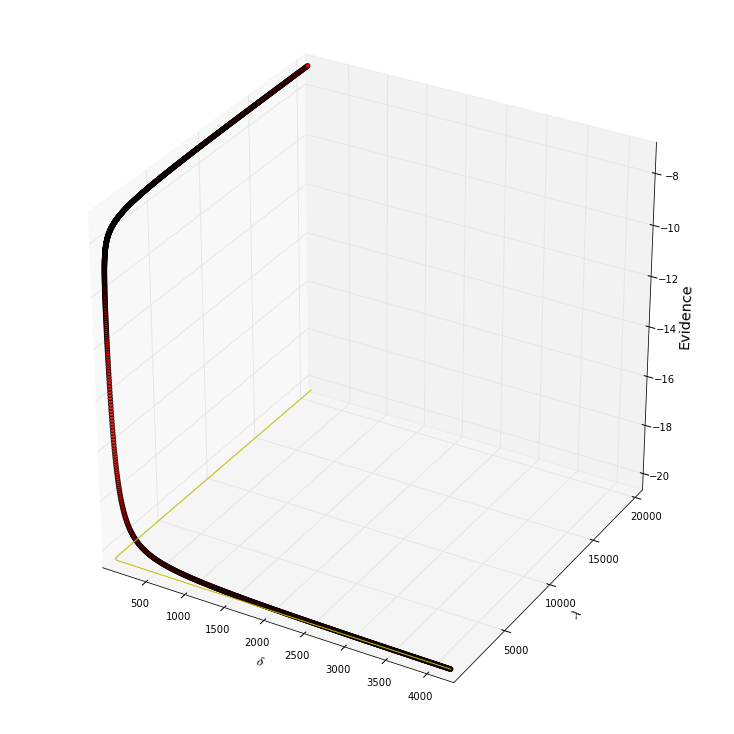

In [249]:
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)
dl, ll, el = delta_list_full[-1], lam_list_full[-1], evid_list_full[-1]
#ax.plot(delta_list[1::2], lam_list[1::2], evid_list[1::2])
ax.scatter(dl[::4], ll[::4], el[::4], c='r')
ax.plot(dl[::4], ll[::4], min(el[::4]), c='y', lw=1)
ax.set_xlim(np.min(dl), np.max(dl))
ax.set_xlabel('$\delta$')
ax.set_ylim(np.min(ll), np.max(ll))
ax.set_ylabel('$\lambda$')
ax.set_zlim(np.min(el), np.max(el))
ax.set_zlabel('Evidence')

### Step 3. A look at the returns

<IPython.core.display.Javascript object>


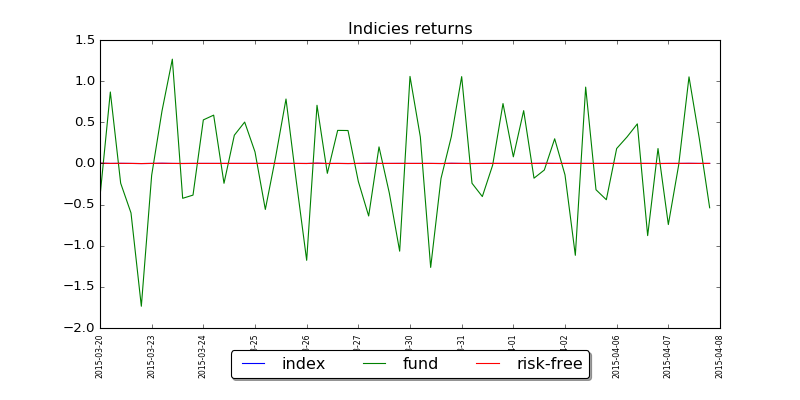

<IPython.core.display.Javascript object>


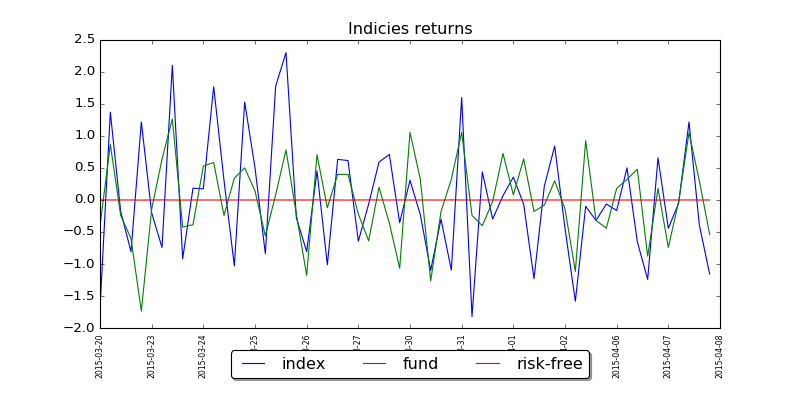

<IPython.core.display.Javascript object>


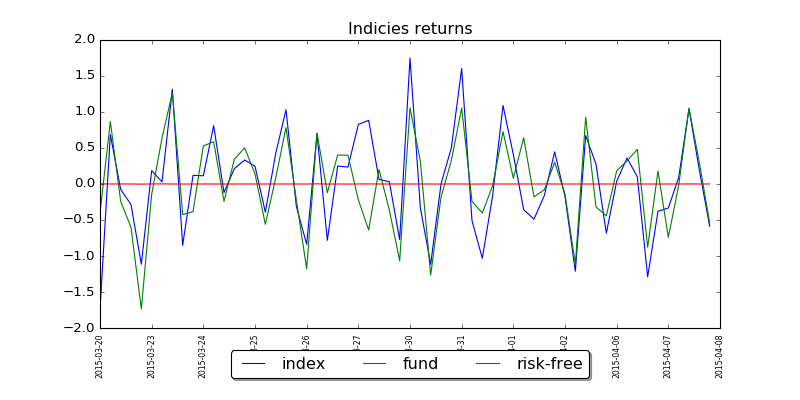

<IPython.core.display.Javascript object>


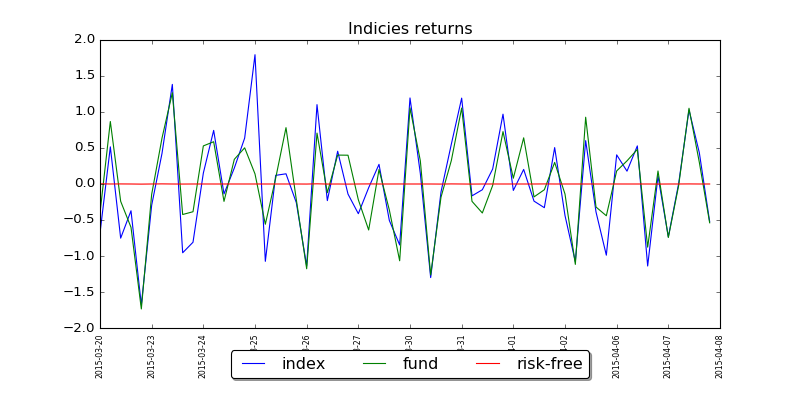

<IPython.core.display.Javascript object>


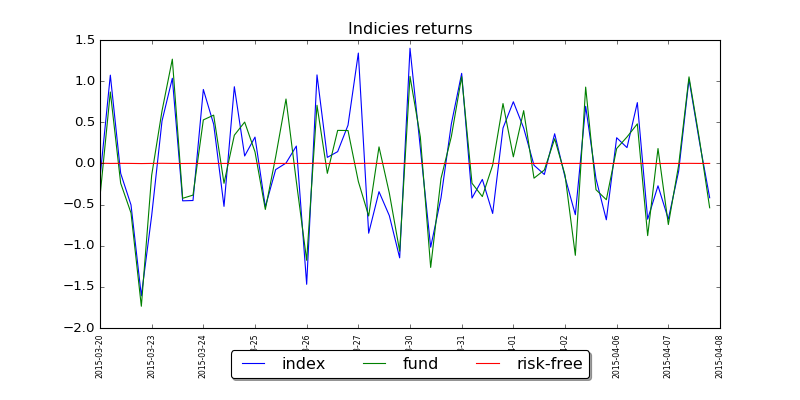

<IPython.core.display.Javascript object>


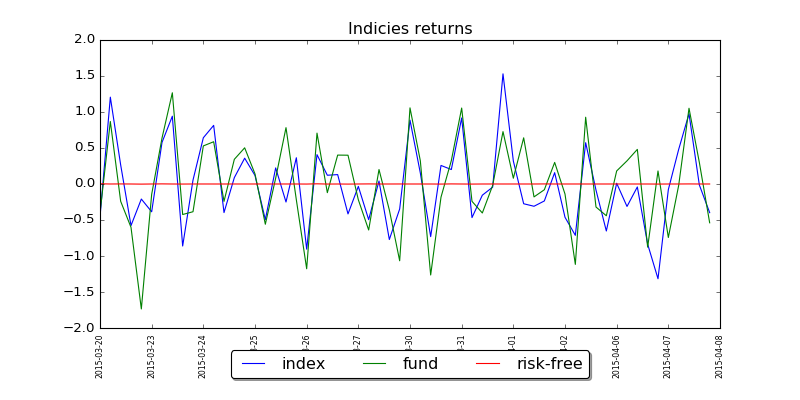

<IPython.core.display.Javascript object>


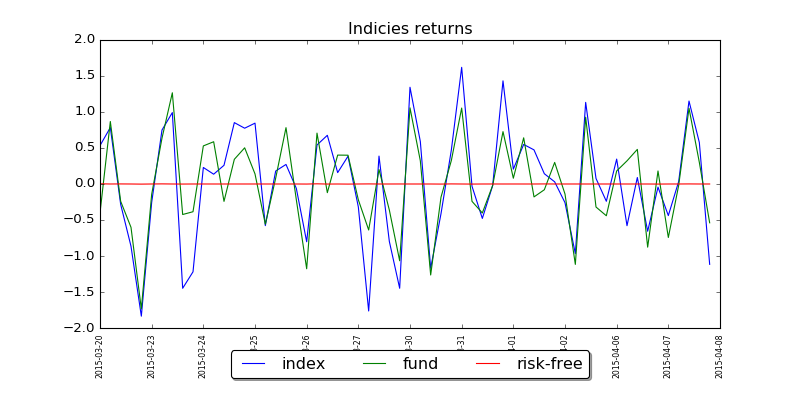

<IPython.core.display.Javascript object>


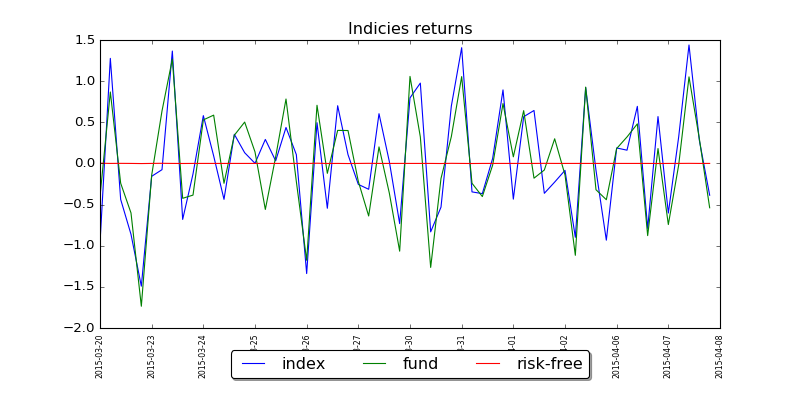

<IPython.core.display.Javascript object>


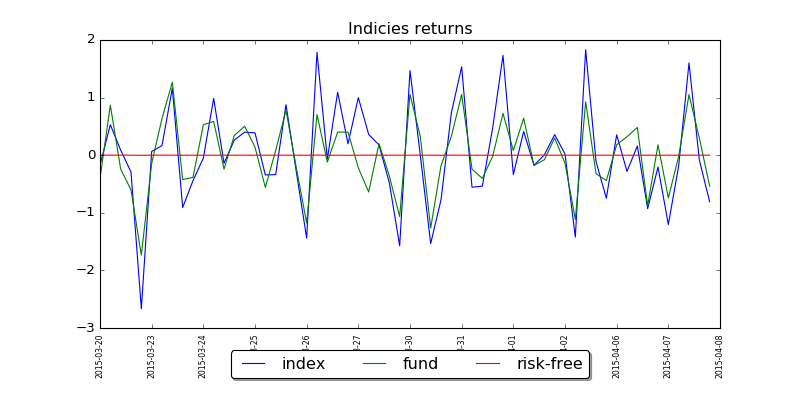

<IPython.core.display.Javascript object>


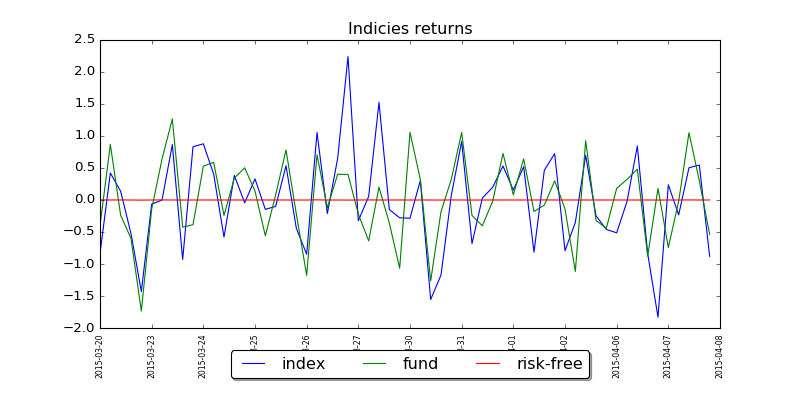

<IPython.core.display.Javascript object>


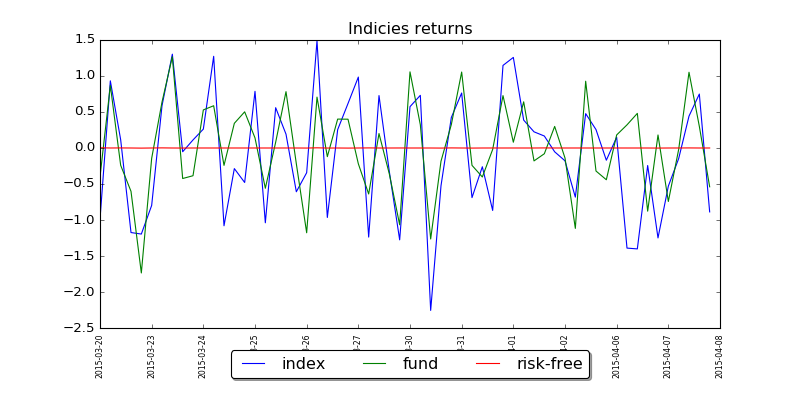

<IPython.core.display.Javascript object>


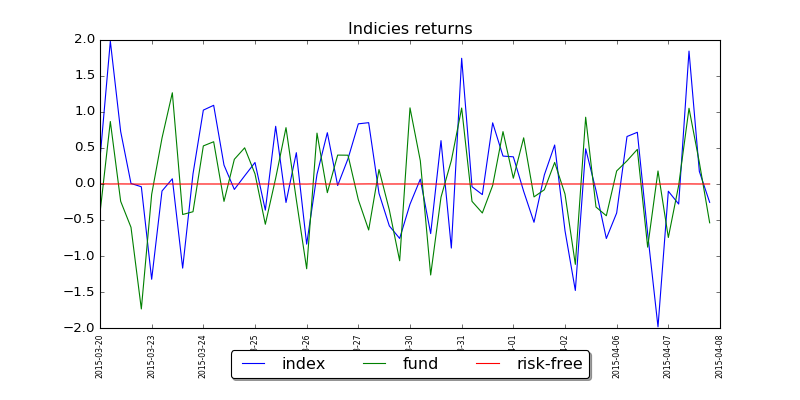

In [4]:
from matplotlib.ticker import MultipleLocator
majorLocator = MultipleLocator(5)



fnum = 0

plt.close("all")

time =  range(T)


#plt.subplot(3,1,1)
for i in range(0,n):
    plt.figure(figsize=(10,5)) 
    plt.title('Indicies returns')
    plt.xticks(time, dates, rotation=90, size = 7)
    ax = plt.gca()
    ax.get_xaxis().set_tick_params(pad=5)
    ax.get_xaxis().set_major_locator(majorLocator)
    plt.plot(time, assetsall[:,i], label = 'index')
    plt.plot(time, fundsall[:,fnum], label = 'fund')
    plt.plot(time, assetsall[:,0], label = 'risk-free')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
    plt.show()

### Step 3. Example of an non-stationary regression

0 0.0267940239028
1 0.0285475177413
2 0.0203713238165
3 0.0113259918905
4 0.0132781473348
5 0.0183694189523
6 0.0253593740527
7 0.0520944955176
8 0.0641039883694
9 0.0965131113588
10 0.129224300845
11 0.157141041188
12 0.17872750184
13 0.194420209238
14 0.194925910666
15 0.187628012701
16 0.200873765113
17 0.18074179491
18 0.20249605566
19 0.21614782155
20 0.216123142288
21 0.203578555776
22 0.199777860441
23 0.199886395879
24 0.19843584859
25 0.193517745057
26 0.174089353033
27 0.154706240273
28 0.142319776115
29 0.130693039854
30 0.114736659098
31 0.101934805705
32 0.0912352395759
33 0.0597268618686
34 0.0406807616629
35 0.0204694268609
36 0.0205499249905
37 0.0267702846818
38 0.0547307937731
39 0.0835491184323
40 0.11318259952
41 0.14250329464
42 0.175481800455
43 0.160457874554
44 0.149707761772
45 0.164474983252
46 0.18858648448
47 0.200504013822
48 0.213672027582
49 0.212145888409
50 0.212525708611
51 0.211074635493
52 0.199383956792
53 0.181615209231
54 0.160324123095
55 0.14361

<IPython.core.display.Javascript object>


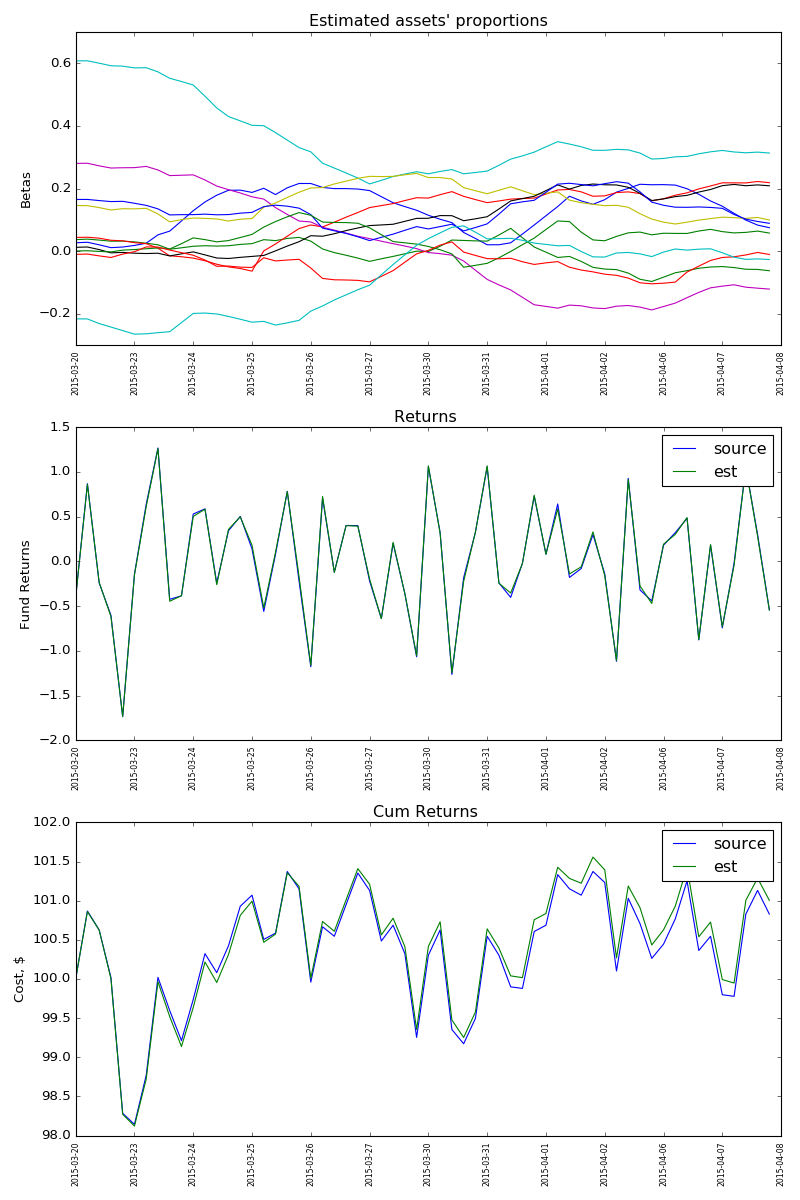

In [8]:
from matplotlib.ticker import MultipleLocator
majorLocator = MultipleLocator(5)


time =  range(T)
outPoint = np.zeros([T,1])
#outPoint[26,0] = outPoint[39,0] = outPoint[41,0] = outPoint[47,0] = outPoint[49,0] = 1
fund = fundsall[:,fnum]
assets = assetsall[:,index_array]
n = np.size(assets,1)
T = np.size(assets,0)

beta, fund_est = nsr.nonstatRegress(assets, fund, lam, outPoint,dynamic_model)
cumfund = nsr.CumReturn(fund)
cumfund_est = nsr.CumReturn(fund_est)

for t in range(0,T):
   print t, beta[t,0]

time =  range(T)
plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
plt.title("Estimated assets' proportions")
plt.xticks(time, dates, rotation=90, size = 7)
ax = plt.gca()
ax.get_xaxis().set_tick_params(pad=5)
ax.get_xaxis().set_major_locator(majorLocator)
ax.set_ylabel('Betas')
#plt.subplot(3,1,2)
for i in range(0,n):
    plt.plot(time, beta[:,i])

plt.show()
# Plot  return
plt.subplot(3,1,2)
plt.title('Returns ')
plt.xticks(time, dates, rotation=90, size = 7)
ax = plt.gca()
ax.get_xaxis().set_tick_params(pad=5)
ax.get_xaxis().set_major_locator(majorLocator)
ax.set_ylabel('Fund Returns')
plt.plot(time, fund, label='source' )
plt.plot(time, fund_est, label='est')
plt.tight_layout() 
plt.legend()
plt.show()
# Plot cumulative return
plt.subplot(3,1,3)
plt.title('Cum Returns ')
plt.xticks(time, dates, rotation=90, size = 7)
ax = plt.gca()
ax.get_xaxis().set_tick_params(pad=5)
ax.get_xaxis().set_major_locator(majorLocator)
plt.plot(time, cumfund, label='source' )
plt.plot(time, cumfund_est, label='est')
ax.set_ylabel('Cost, $')
plt.tight_layout() 
plt.legend()
plt.show()

### Step 4. Example of cross-validation procedure for fixed smoothness value

0.0693157685506


<IPython.core.display.Javascript object>


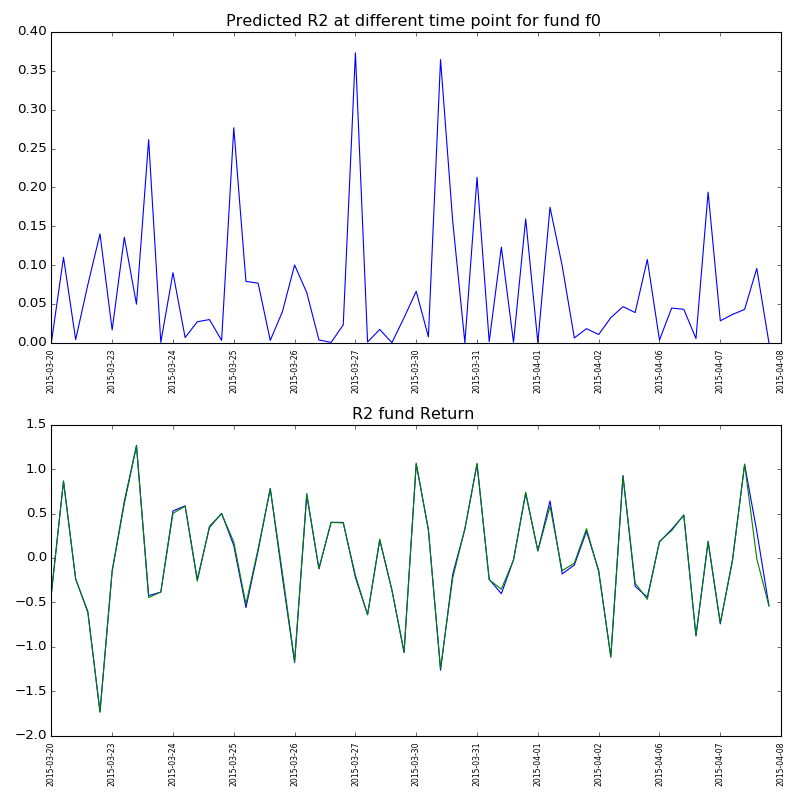

In [14]:
from matplotlib.ticker import MultipleLocator
majorLocator = MultipleLocator(5)


# Cross-validation (Leave-one_out procedure)
fund = fundsall[:,fnum]
assets = assetsall[:,index_array]
n = np.size(assets,1)
T = np.size(assets,0)
arrR2, r2, fund_out = nsr.LeaveOneOut(assets,fund,lam,dynamic_model)
cumfund = nsr.CumReturn(fund)
cumfund_out = nsr.CumReturn(fund_out)
print r2    
# Plot PR2
time =  range(T)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Predicted R2 at different time point for fund f0 ')
plt.xticks(time, dates, rotation=90, size = 7)
ax = plt.gca()
ax.get_xaxis().set_tick_params(pad=5)
ax.get_xaxis().set_major_locator(majorLocator)
plt.plot(time, arrR2)
plt.show()
# Plot cumulative return
plt.subplot(2,1,2)
plt.title('R2 fund Return ')
plt.xticks(time, dates, rotation=90, size = 7)
ax = plt.gca()
ax.get_xaxis().set_tick_params(pad=5)
ax.get_xaxis().set_major_locator(majorLocator)
plt.plot(time, fund)
plt.plot(time, fund_out)
plt.tight_layout() 

plt.show()

### Step 5. Example of cross-validation procedure for fixed smoothness value for all funds 

In [ ]:
# Cross-validation (Leave-one_out procedure)
import matplotlib.pyplot as pyplot

assets = assetsall[:,index_array]
n = np.size(assets,1)
T = np.size(assets,0)
# Plot PR2
time =  range(T)

plt.figure(figsize=(10,5)) 

plt.title('Predicted R2 at different time point and multiple funds ')
plt.xticks(time, dates, rotation=90, size = 7)
ax = plt.gca()
ax.get_xaxis().set_tick_params(pad=5)
ax.get_xaxis().set_major_locator(majorLocator)
for i in range(157):
    arrR2, r2, fund_out = nsr.LeaveOneOut(assets,fundsall[:,i],lam,dynamic_model)
    plt.plot(time, arrR2)
   
plt.show()

### Step 6.0.-1!!! LOO with  independent data !!!(generating with normal distr new X)

[ 0.98152433  0.983346    0.97911864  0.97506753  0.97514517  0.96297655
  0.95299714  0.93606703  0.91515567  0.92214493  0.92997721  0.93085593
  0.92395785  0.91676354  0.91126218  0.90409234  0.91541208  0.91819851
  0.923022    0.91822294  0.91187793  0.89819535  0.89603944  0.89400388
  0.8944573   0.89372857  0.90217348  0.91005743  0.92079235  0.92965809
  0.92891399  0.92993899  0.93038775  0.90285735  0.88491145  0.86782344
  0.87236963  0.8869986   0.89606806  0.90523536  0.91964727  0.93375278
  0.94244887  0.94784451  0.95322231  0.95909164  0.96791627  0.96195
  0.95025281  0.93732352  0.93400418  0.93105929  0.92911435  0.92716365
  0.92239198  0.9170815   0.90586565  0.89464751  0.89060988  0.88366876]
0.471166048851
0.0466107051464


<IPython.core.display.Javascript object>


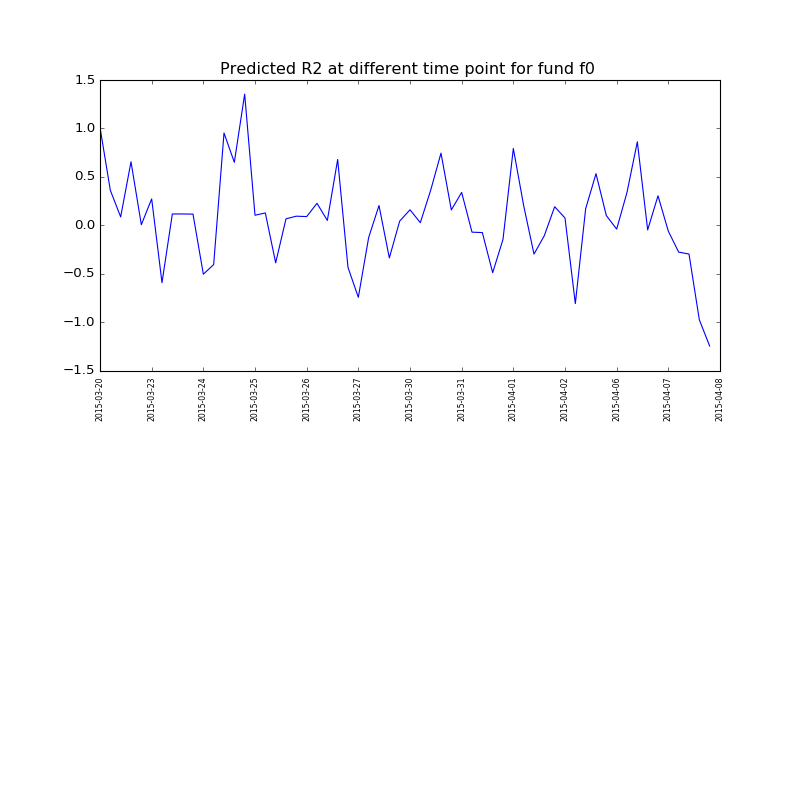

<IPython.core.display.Javascript object>


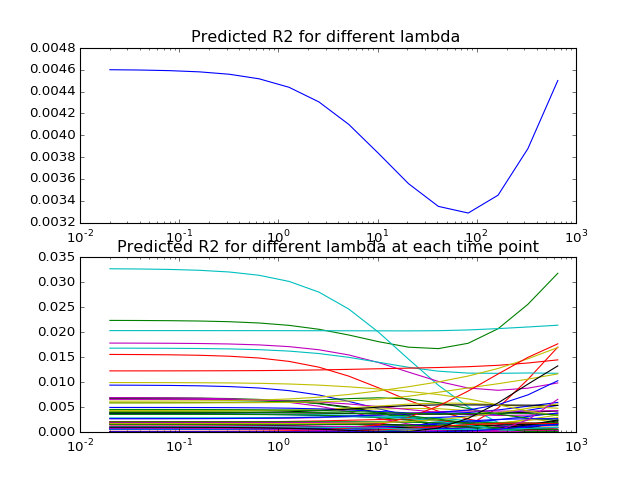

<IPython.core.display.Javascript object>


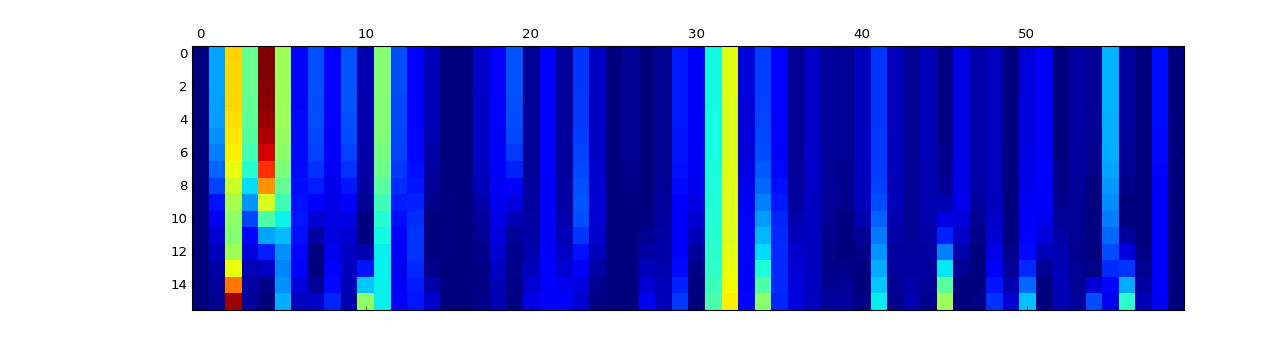

<IPython.core.display.Javascript object>


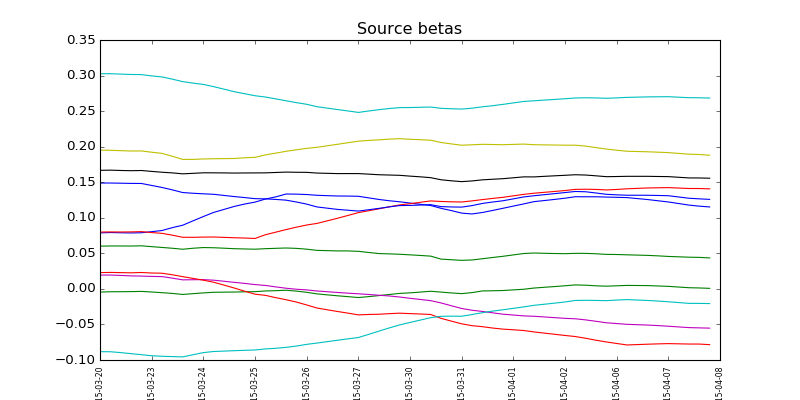

<IPython.core.display.Javascript object>


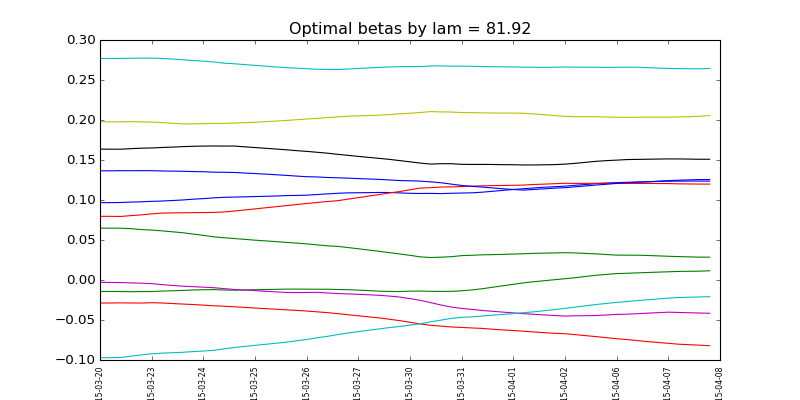

In [15]:
from matplotlib.ticker import MultipleLocator
majorLocator = MultipleLocator(5)

time =  range(T)
outPoint = np.zeros([T,1])
fund = fundsall[:,fnum]
assets = assetsall[:,index_array]
n = np.size(assets,1)
T = np.size(assets,0)

lam = 100
beta, fund_est = nsr.nonstatRegress(assets, fund, lam, outPoint,dynamic_model)
print(np.sum(beta, 1))
assets_rand = np.random.np.random.normal(0,1,[T,n])
assets_rand = np.mat(assets_rand)
fund_rand = np.zeros([T,1])
for t in range(0,T):
        assets_t = assets_rand[t,:]
        beta_t = beta[t,:]
        fund_rand[t,0] = np.dot(beta_t,assets_t.T)    
std_fund =  np.std(fund_rand)   
print(std_fund)


noise = np.random.normal(0,0.1*std_fund,[T,1])   
print(np.std(noise))

fund_rand  = fund_rand + noise    

from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as pyplot
majorLocator = MultipleLocator(5)

time =  range(T)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Predicted R2 at different time point for fund f0 ')
plt.xticks(time, dates, rotation=90, size = 7)
ax = plt.gca()
ax.get_xaxis().set_tick_params(pad=5)
ax.get_xaxis().set_major_locator(majorLocator)
plt.plot(time, fund_rand)
plt.show()



lam_arr = []
lam = 0.01
while lam <=500:
    lam = lam*2
    lam_arr.append(lam)

r2_lam_arr = []
r2_lam_t = np.zeros([len(lam_arr),T]) 
ilam = 0
for lam in lam_arr:
     r2_arr, r2_lam, fund_out = nsr.LeaveOneOut(assets_rand,fund_rand,lam,dynamic_model)
     r2_lam_t[ilam,:] = r2_arr.T 
     r2_lam_arr.append(r2_lam)
     ilam = ilam+1
    
#print  r2_lam_arr


plt.figure()
plt.subplot(2,1,1)
plt.title('Predicted R2 for different lambda ')
ax = plt.gca()
ax.set_xscale('log')
plt.plot(lam_arr,r2_lam_arr)

plt.subplot(2,1,2)
plt.title('Predicted R2 for different lambda at each time point')
for t in range(1,T-1):
    r2_t = r2_lam_t[:,t]
    plt.plot(lam_arr,r2_t)
ax = plt.gca()
ax.set_xscale('log')    
pyplot.matshow(r2_lam_t)    
plt.figure(figsize=(10,5))
plt.title('Source betas')
for i in range(0,n):
    plt.plot(time, beta[:,i])    
plt.xticks(time, dates, rotation=90, size = 7)
ax = plt.gca()
ax.get_xaxis().set_tick_params(pad=5)
ax.get_xaxis().set_major_locator(majorLocator)

argminlam  = lam_arr[np.argmin(r2_lam_arr)]
beta_opt_lam, fund_est = nsr.nonstatRegress(assets_rand,fund_rand, argminlam, outPoint,dynamic_model)
plt.figure(figsize=(10,5))
title = 'Optimal betas by lam = ' + str(argminlam)
plt.title(title)
for i in range(0,n):
    plt.plot(time, beta_opt_lam[:,i])
plt.xticks(time, dates, rotation=90, size = 7)
ax = plt.gca()
ax.get_xaxis().set_tick_params(pad=5)
ax.get_xaxis().set_major_locator(majorLocator)    

### Step 6.0.0 LOO procedure  for factor assets

**Exploring eigenvectors** !!!

In [ ]:
assetss  = assetsall[:,np.array([1,2,3,4,5,6,7,8,9,10,11])] 

n = np.size(assetss,1)
T = np.size(assetss,0)
A  = np.zeros([T,T])
for i in range(0,n):
    A = A + assetss[:,i] * assetss[:,i].T
#print(XXT)
eigvals, eigenvec = np.linalg.eig(A.astype("float64"))

ind = np.argsort(eigvals,)
ind = ind[::-1]
eigenvec = eigenvec[:, ind]
eigvals = eigvals[ind]
eigvals = eigvals.real
eigenvec =eigenvec.real

m=4

assets_ort = eigenvec[:,range(0,m)]





time =  range(T)
outPoint = np.zeros([T,1])
fund = fundsall[:,fnum]

n = np.size(assets_ort,1)
T = np.size(assets_ort,0)






plt.figure(figsize=(10,5)) 
plt.title('Factors')
plt.xticks(time, dates, rotation=90, size = 7)
ax = plt.gca()
ax.get_xaxis().set_tick_params(pad=5)


ax.get_xaxis().set_major_locator(majorLocator)

#plt.subplot(3,1,1)
for i in range(0,n):
    plt.plot(time, math.sqrt(eigvals[i])*assets_ort[:,i])
plt.show()

lam_arr = []
lam = 0.01
while lam <=500:
    lam = lam*2
    lam_arr.append(lam)

r2_lam_arr = []
r2_lam_t = np.zeros([len(lam_arr),T]) 
ilam = 0
for lam in lam_arr:
     r2_arr, r2_lam, fund_out = nsr.LeaveOneOut(assets_ort,fund,lam,dynamic_model)
     r2_lam_t[ilam,:] = r2_arr.T 
     r2_lam_arr.append(r2_lam)
     ilam = ilam+1
    
#print  r2_lam_arr


plt.figure()
plt.subplot(2,1,1)
plt.title('Predicted R2 for different lambda ')
ax = plt.gca()
ax.set_xscale('log')
plt.plot(lam_arr,r2_lam_arr)

plt.subplot(2,1,2)
plt.title('Predicted R2 for different lambda at each time point')
for t in range(1,T-1):
    r2_t = r2_lam_t[:,t]
    plt.plot(lam_arr,r2_t)
ax = plt.gca()
ax.set_xscale('log')    
#pyplot.matshow(r2_lam_t)    

argminlam  = lam_arr[np.argmin(r2_lam_arr)]
beta_opt_lam, fund_est = nsr.nonstatRegress(assets_ort,fund, argminlam, outPoint,dynamic_model)
plt.figure(figsize=(10,5))
title = 'Optimal betas by lam = ' + str(argminlam)
plt.title(title)
for i in range(0,n):
    plt.plot(time, beta_opt_lam[:,i])
plt.xticks(time, dates, rotation=90, size = 7)
ax = plt.gca()
ax.get_xaxis().set_tick_params(pad=5)
ax.get_xaxis().set_major_locator(majorLocator)  
plt.show()

# Plot  return
plt.figure(figsize=(10,5))
plt.title('R2 fund Return ')
plt.xticks(time, dates, rotation=90, size = 7)
ax = plt.gca()
ax.get_xaxis().set_tick_params(pad=5)
ax.get_xaxis().set_major_locator(majorLocator)
plt.plot(time, fund)
plt.plot(time, fund_est)
plt.tight_layout() 

plt.show()

**LOO procedure  for factor assets** !!!

In [4]:
assetss[:,i] * assetss[:,i].T

NameError: name 'assetss' is not defined

<IPython.core.display.Javascript object>


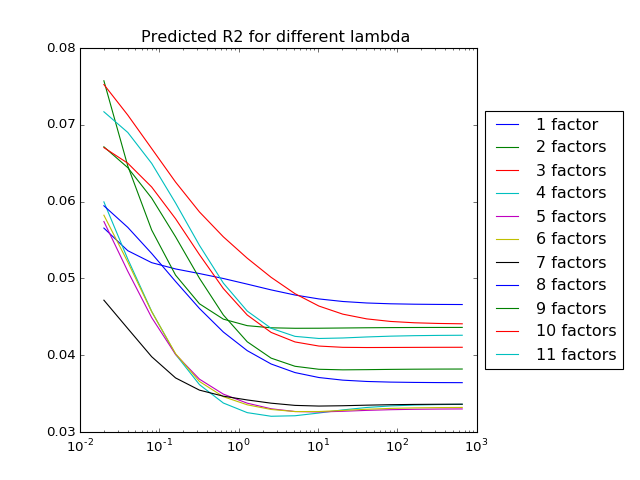

4 2.56 0.0320496053629


<IPython.core.display.Javascript object>


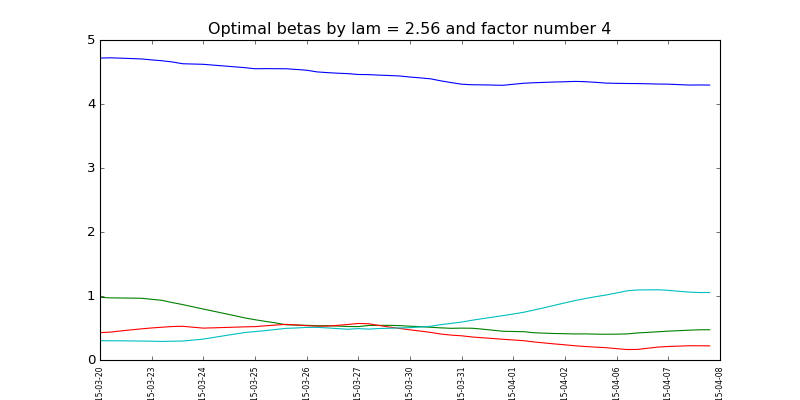

<IPython.core.display.Javascript object>


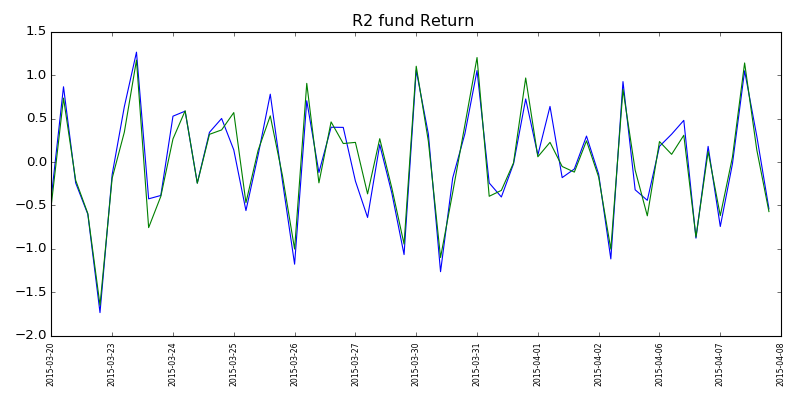

In [13]:
from matplotlib.ticker import MultipleLocator
majorLocator = MultipleLocator(5)



assetss  = assetsall[:,np.array([1,2,3,4,5,6,7,8,9,10,11])] 

n = np.size(assetss,1)
T = np.size(assetss,0)
A  = np.zeros([T,T])
for i in range(0,n):
    A = A + assetss[:,i] * assetss[:,i].T
#print(XXT)
eigvals, eigenvec = np.linalg.eig(A.astype("float64"))

ind = np.argsort(eigvals,)
ind = ind[::-1]
eigenvec = eigenvec[:, ind]
eigvals = eigvals[ind]
eigenvec =eigenvec.real

time =  range(T)
outPoint = np.zeros([T,1])
fund = fundsall[:,fnum]



lam_arr = []
lam = 0.001
while lam <=5:
        lam = lam*2
        lam_arr.append(lam)
plt.close("all")

plt.figure()
plt.title('Predicted R2 for different lambda ')
ax = plt.gca()
ax.set_xscale('log')


m_max = 11
r2_min = 1000
m_min  = 0
lam_min = 0
r2_lam_arr = np.zeros([m_max,len(lam_arr)]) 

for m in range(0,m_max):
        assets_ort = eigenvec[:,range(0,m+1)]
        n = np.size(assets_ort,1)
        T = np.size(assets_ort,0)       
        
        ilam = 0
        
        for lam in lam_arr:
             r2_arr, r2_lam, fund_out = nsr.LeaveOneOut(assets_ort,fund,lam,dynamic_model)
             r2_lam_arr[m,ilam] = r2_lam 
             ilam = ilam+1
             if r2_lam <= r2_min:           
                r2_min = r2_lam
                m_min = m
                lam_min  = lam
        if m == 0: 
          series_labl =  str(m+1) + ' factor'
        else:
          series_labl =  str(m+1) + ' factors'  
        plt.plot(lam_arr,r2_lam_arr[m,:], label = series_labl)
box = ax.get_position()

ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.show()        
print m_min+1, lam_min, r2_min

assets_ort = eigenvec[:,range(0,m_min+1)]
beta_opt_lam, fund_est = nsr.nonstatRegress(assets_ort,fund, lam_min, outPoint,dynamic_model)
plt.figure(figsize=(10,5))
title = 'Optimal betas by lam = ' + str(lam_min) + ' and factor number ' + str(m_min+1) 
plt.title(title)
for i in range(0,m_min+1):
    plt.plot(time, beta_opt_lam[:,i])
plt.xticks(time, dates, rotation=90, size = 7)
ax = plt.gca()
ax.get_xaxis().set_tick_params(pad=5)
ax.get_xaxis().set_major_locator(majorLocator)  
plt.show()

# Plot  return
plt.figure(figsize=(10,5))
plt.title('R2 fund Return ')
plt.xticks(time, dates, rotation=90, size = 7)
ax = plt.gca()
ax.get_xaxis().set_tick_params(pad=5)
ax.get_xaxis().set_major_locator(majorLocator)
plt.plot(time, fund)
plt.plot(time, fund_est)
plt.tight_layout() 

plt.show()

### Step 6. LOO procedure  for smoothness adjustment

### Step 6.1 Leave one out procedure  for smoothness adjustment

In [ ]:
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as pyplot
majorLocator = MultipleLocator(5)
assets = assetsall[:,index_array]
n = np.size(assets,1)
T = np.size(assets,0)

outPoint = np.zeros([T,1])
fund = fundsall[:,fnum]
time =  range(T)
lam_arr = []
lam = 0.001
while lam <=5:
    lam = lam*2
    lam_arr.append(lam)
band = 10

r2_lam_arr_clear = []
r2_lam_arr = []
r2_lam_t = np.zeros([len(lam_arr),T]) 
ilam = 0
#outPoint[26,0] = outPoint[39,0] = outPoint[41,0] = outPoint[47,0] = outPoint[49,0] = 1
for lam in lam_arr:
     r2_arr, r2_lam, fund_out = nsr.LeaveOneOut(assets,fund,lam,dynamic_model)
     beta_opt_lam, fund_est = nsr.nonstatRegress(assets,fund, lam, outPoint,dynamic_model)   
     r2_lam_t[ilam,:] = r2_arr.T
     err = fund_est - fund    
     r2_lam_clear = np.dot(err.T, err)
       
     r2_lam_arr.append(r2_lam)
        
     r2_lam_arr_clear.append(r2_lam_clear[0,0]/T) 
     #import ipdb; ipdb.set_trace() 
     ilam = ilam+1

<IPython.core.display.Javascript object>


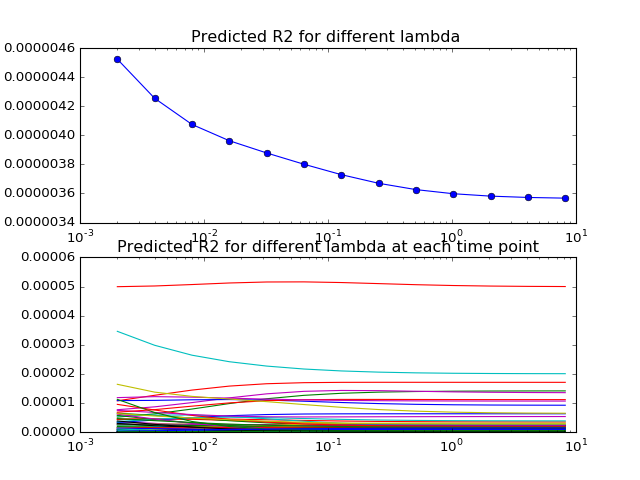

<IPython.core.display.Javascript object>


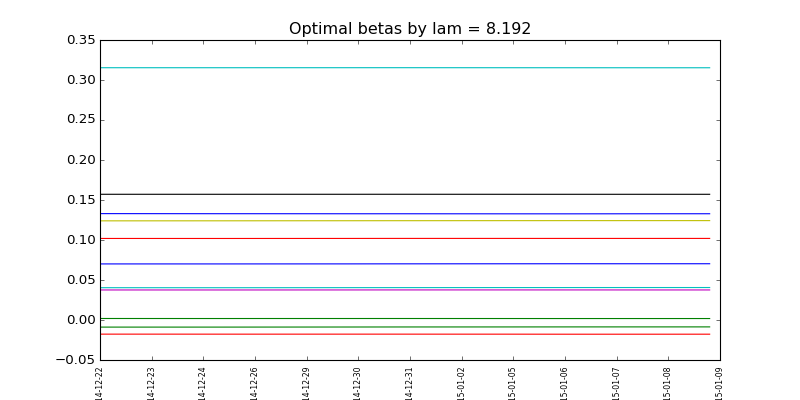

<IPython.core.display.Javascript object>


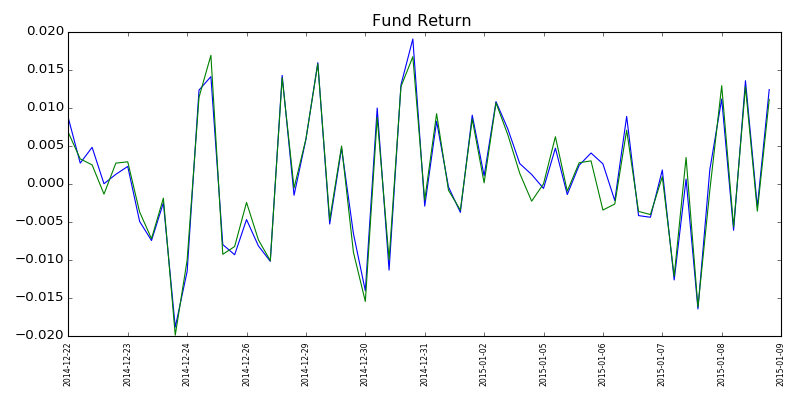

In [158]:
#print  r2_lam_arr
plt.close("all")


plt.figure()
plt.subplot(2,1,1)
plt.title('Predicted R2 for different lambda ')
ax = plt.gca()
ax.set_xscale('log')
plt.plot(lam_arr,r2_lam_arr, '-o')


plt.subplot(2,1,2)
plt.title('Predicted R2 for different lambda at each time point')
for t in range(1,T-1):
    r2_t = r2_lam_t[:,t]
    plt.plot(lam_arr,r2_t)
ax = plt.gca()
ax.set_xscale('log')    



# pyplot.matshow(r2_lam_t)


argminlam  = lam_arr[np.argmin(r2_lam_arr)]

beta_opt_lam, fund_est = nsr.nonstatRegress(assets,fund, argminlam, outPoint,dynamic_model)
plt.figure(figsize=(10,5))
title = 'Optimal betas by lam = ' + str(argminlam) 
plt.title(title)
for i in range(0,n):
    plt.plot(time, beta_opt_lam[:,i])
plt.xticks(time, dates, rotation=90, size = 7)
ax = plt.gca()
ax.get_xaxis().set_tick_params(pad=5)
ax.get_xaxis().set_major_locator(majorLocator)  
plt.show()

# Plot  return
plt.figure(figsize=(10,5))
plt.title('Fund Return ')
plt.xticks(time, dates, rotation=90, size = 7)
ax = plt.gca()
ax.get_xaxis().set_tick_params(pad=5)
ax.get_xaxis().set_major_locator(majorLocator)
plt.plot(time, fund, label = 'source')
plt.plot(time, fund_est, label = 'estimated')
plt.tight_layout()

plt.show()

### Step 6.1.1 (120 days funds) Leave one out procedure  for smoothness adjustment 

### Step 6.2 !!! Leave half out procedure  for smoothness adjustment

<IPython.core.display.Javascript object>


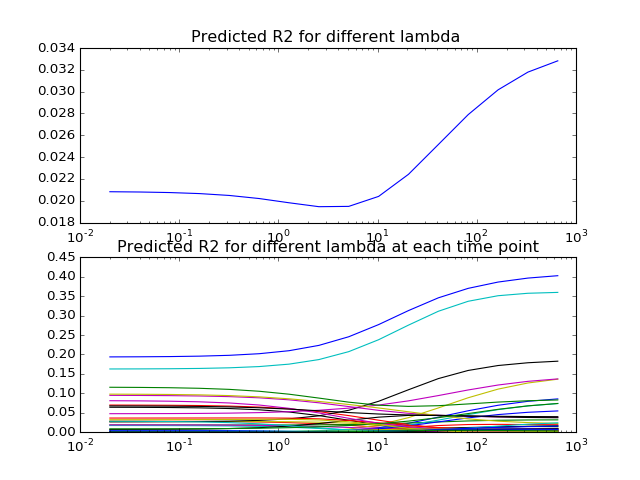

<IPython.core.display.Javascript object>


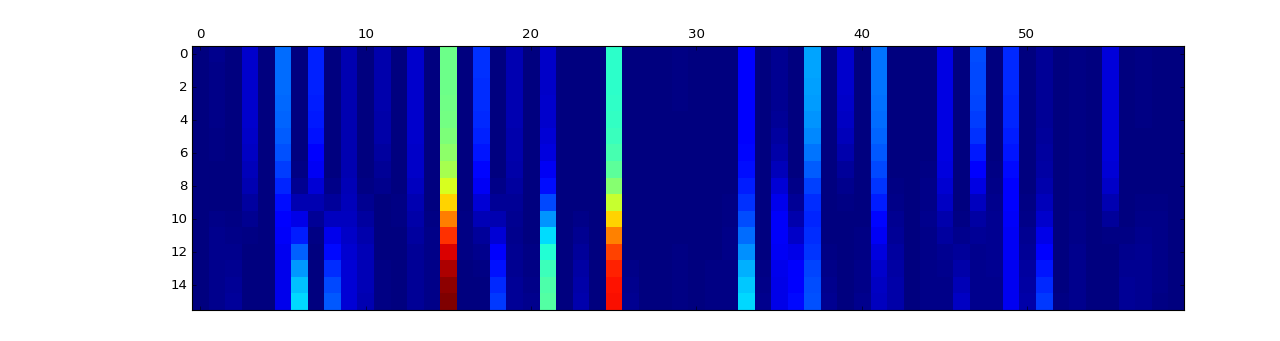

In [15]:
from matplotlib.ticker import MultipleLocator
majorLocator = MultipleLocator(5)


fund = fundsall[:,fnum]
assets = assetsall[:,index_array]
lam_arr = []
lam = 0.01
while lam <=500:
    lam = lam*2
    lam_arr.append(lam)
band = 10

r2_lam_arr = []

r2_lam_t = np.zeros([len(lam_arr),T]) 
ilam = 0
for lam in lam_arr:
     r2_arr, r2_lam, fund_out = nsr.LeaveHalfOut(assets,fund,lam,dynamic_model)
     r2_lam_t[ilam,:] = r2_arr.T    
     r2_lam_arr.append(r2_lam)
     ilam = ilam+1
#print  r2_lam_arr   

plt.figure()

plt.subplot(2,1,1)
plt.title('Predicted R2 for different lambda ')
ax = plt.gca()
ax.set_xscale('log')
plt.plot(lam_arr,r2_lam_arr)

plt.subplot(2,1,2)
plt.title('Predicted R2 for different lambda at each time point')
for t in range(1,T-1):
    r2_t = r2_lam_t[:,t]
    plt.plot(lam_arr,r2_t)
ax = plt.gca()
ax.set_xscale('log')    

pyplot.matshow(r2_lam_t)


### Step 7. Akaike information criterion  for smoothness adjustment with known observation variance 

<IPython.core.display.Javascript object>


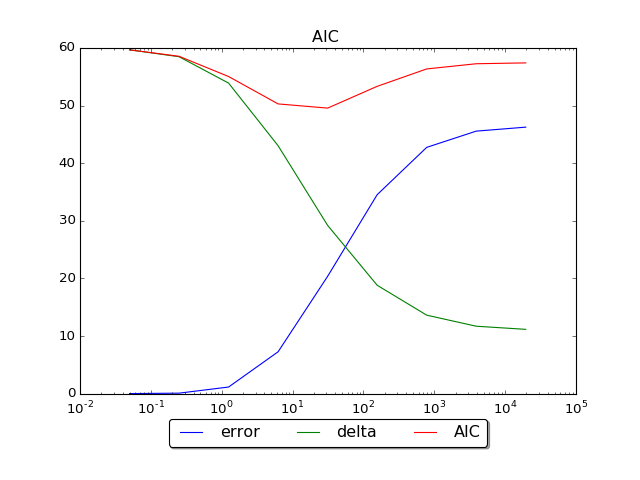

In [26]:
from matplotlib.ticker import MultipleLocator
majorLocator = MultipleLocator(5)


fund = fundsall[:,fnum]
assets = assetsall[:,index_array]
lam_arr = []
lam = 0.01
while lam <=5000:
    lam = lam*5
    lam_arr.append(lam)


r2_lam_arr = []
tr_lam_arr = []
arr = []
for lam in lam_arr:
     r2_lam, trace_lam = nsr.AIC(assets,fund,lam,dynamic_model)
     r2_lam_arr.append(r2_lam*30)
     tr_lam_arr.append(trace_lam)
#print  r2_lam_arr   
plt.figure()
plt.title('AIC ')
ax = plt.gca()
ax.set_xscale('log')
new_r2_lam_arr = [x *T  for x in  r2_lam_arr]
tr_lam_arr = [x for x in  tr_lam_arr]
aic = [x +y  for x, y in zip(new_r2_lam_arr,tr_lam_arr)]
plt.plot(lam_arr,new_r2_lam_arr, label='error')
plt.plot(lam_arr,tr_lam_arr, label='delta')
plt.plot(lam_arr,aic, label='AIC')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)

###  Step 7. Implicit cross-validation crieterion with unknown observation variance

[-394.4602719772124, -301.8397969161464, -220.92140962257025, -165.39155883682045, -134.45715530852357, -118.60990112940215, -112.20637540106073]


<IPython.core.display.Javascript object>


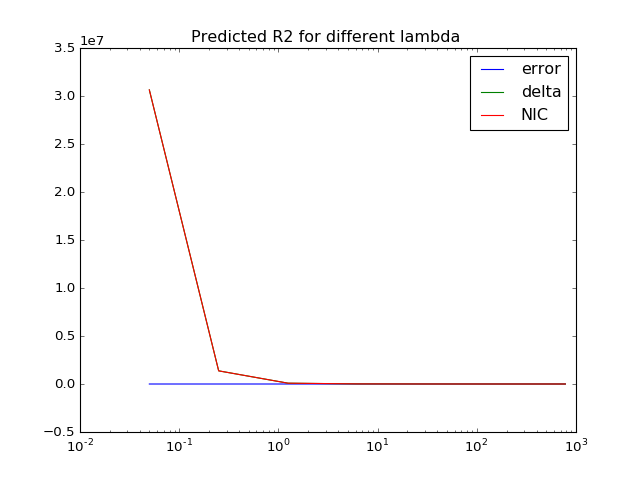

In [27]:
from matplotlib.ticker import MultipleLocator
majorLocator = MultipleLocator(5)


fund = fundsall[:,fnum]
assets = assetsall[:,index_array]
n = np.size(assets,1)
T = np.size(assets,0)
lam_arr = []
lam = 0.01
while lam <=500:
    lam = lam*5
    lam_arr.append(lam)


r2_lam_arr = []
tr_lam_arr = []
arr = []
for lam in lam_arr:
     r2_lam, trace_lam = nsr.AIC(assets,fund,lam,dynamic_model)
     ln_r2  = T*math.log(r2_lam)/2   
     r2_lam_arr.append(ln_r2)
     sig_trace_lam  =   trace_lam/r2_lam 
     tr_lam_arr.append(sig_trace_lam)
     
print  r2_lam_arr
plt.figure()
plt.title('Predicted R2 for different lambda ')
ax = plt.gca()
ax.set_xscale('log')
#import ipdb; ipdb.set_trace()
new_r2_lam_arr = [x  for x in r2_lam_arr]
aic = [x +y  for x, y in zip(new_r2_lam_arr,tr_lam_arr)]
plt.plot(lam_arr,new_r2_lam_arr, label='error')
plt.plot(lam_arr,tr_lam_arr, label='delta')

#aic = np.sum(r2_lam_arr+tr_lam_arr)
plt.plot(lam_arr,aic, label='NIC')
plt.legend()

# KVASOVS!

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import Regress as nsr
import math
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib notebook

In [269]:
dynamic_model = 0

In [4]:
# set smoothness
lam = 0.99
# indicies
index_array = np.arange(12)
index_array = np.array([1,2,3,4,5,6,7,8,9,10,11])
# set model matrix
dynamic_model = 0
import time
import matplotlib.gridspec as gridspec

from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
majorLocator = MultipleLocator(5)

T,n = assetstbl.shape
# fund
fnum = 0

time =  range(T)
fnums = np.arange(20)
fnames = fundnames #shorten names not needed (but 108 symbols long)

In [77]:
sns.reset_orig()

In [74]:
import seaborn as sns
sns.set_style("whitegrid")

In [171]:
#outPoint[26,0] = outPoint[39,0] = outPoint[41,0] = outPoint[47,0] = outPoint[49,0] = 1
fund = fundsall[:,fnum]
assets = assetsall[:,index_array]
n = np.size(assets,1)
T = np.size(assets,0)
time =  range(T)
outPoint = np.zeros([T,1])

beta, fund_est = nsr.nonstatRegress(assets, fund, lam, outPoint,dynamic_model)
cumfund = nsr.CumReturn(fund)
cumfund_est = nsr.CumReturn(fund_est)

<IPython.core.display.Javascript object>


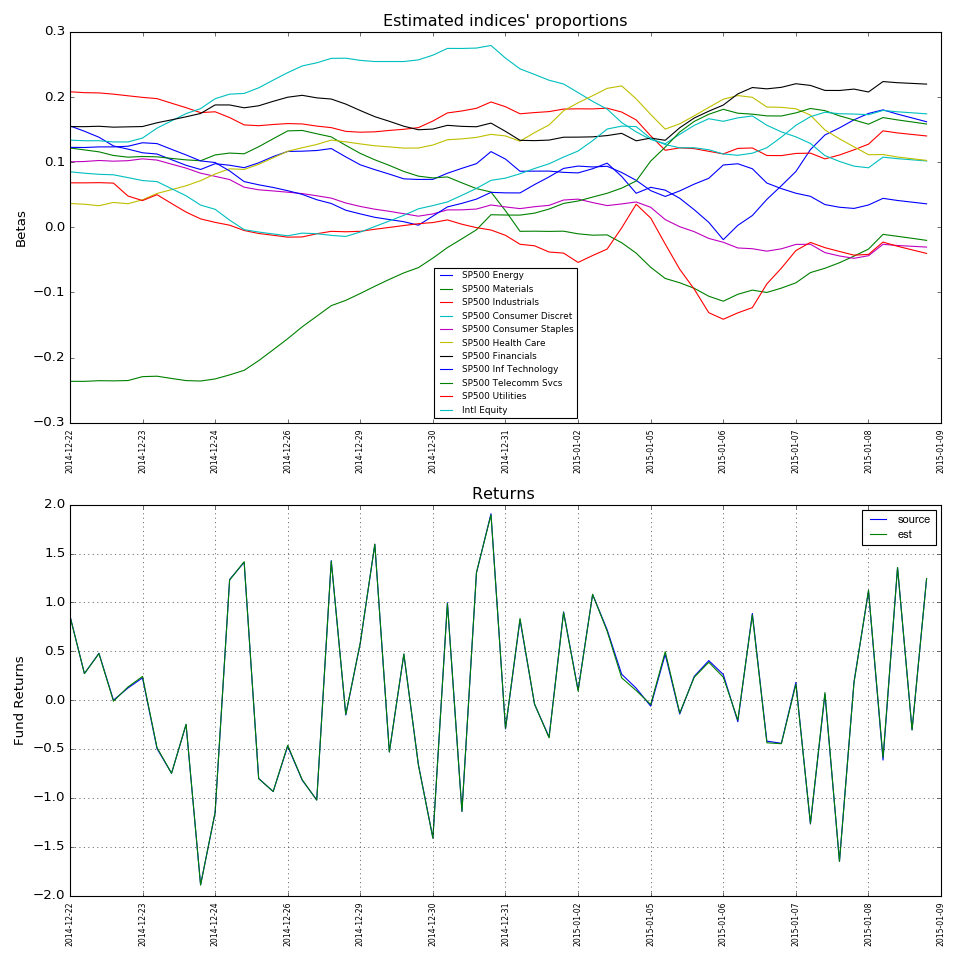

In [172]:
time =  range(T)
fig = plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.title("Estimated indices' proportions")
plt.xticks(time, dates, rotation=90, size = 7)
ax = plt.gca()
ax.get_xaxis().set_tick_params(pad=5)
ax.get_xaxis().set_major_locator(majorLocator)
ax.set_ylabel('Betas')
for i in range(0,n):
    plt.plot(time, beta[:,i], label=assetnames[i+1])
plt.legend(fontsize=8, loc='lower centre')

# Plot  return
plt.subplot(2,1,2)
plt.title('Returns ')
plt.xticks(time, dates, rotation=90, size = 7)
ax = plt.gca()
ax.get_xaxis().set_tick_params(pad=5)
ax.get_xaxis().set_major_locator(majorLocator)
ax.set_ylabel('Fund Returns')
ax.grid('on')
plt.plot(time, fund, label='source' )
add_it = np.asarray(assetsall[:,0])*(1-np.sum(beta, axis=1)).reshape(-1, 1)
plt.plot(time, fund_est + add_it, label='est')
plt.tight_layout() 
plt.legend(fontsize=10)
plt.show()
# # Plot cumulative return
# plt.subplot(3,1,3)
# plt.title('Cum Returns ')
# plt.xticks(time, dates, rotation=90, size = 7)
# ax = plt.gca()
# ax.get_xaxis().set_tick_params(pad=5)
# ax.get_xaxis().set_major_locator(majorLocator)
# plt.plot(time, cumfund, label='source' )
# plt.plot(time, cumfund_est, label='est')
# ax.set_ylabel('Cost, $')
# plt.tight_layout() 
# plt.legend()
# plt.show()
fig.savefig('pic/'+'example_nsr'+'.png', dpi=200)

GOOD!

<IPython.core.display.Javascript object>


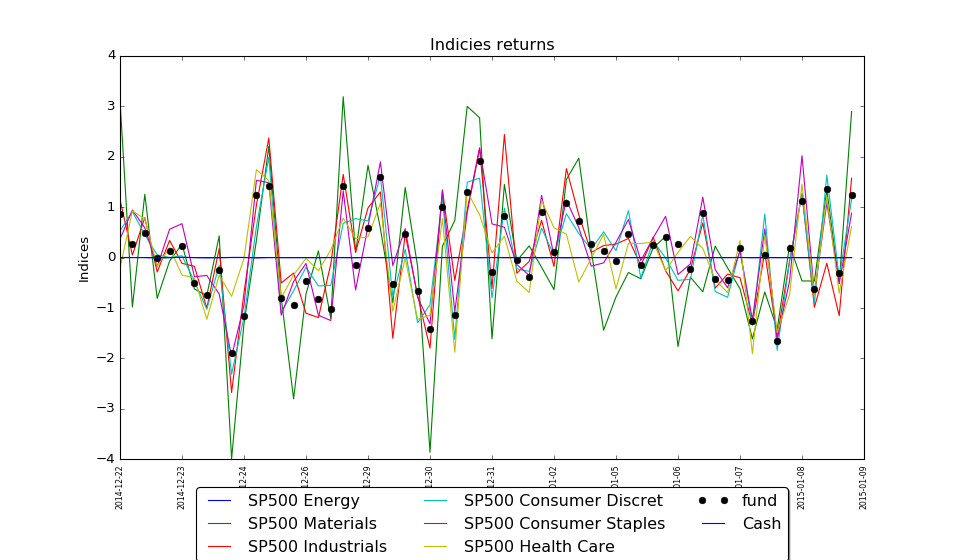

In [173]:
fnum = 0
plt.close("all")

time =  range(T)
#plt.subplot(3,1,1)
fig = plt.figure(figsize=(12,7)) 
plt.title('Indicies returns')
plt.xticks(time, dates, rotation=90, size = 7)
ax = plt.gca()
ax.get_xaxis().set_tick_params(pad=5)
ax.get_xaxis().set_major_locator(majorLocator)
ax.set_ylabel('Indices')
for i in range(0,6):
    ax.plot(time, assetsall[:,i], label = assetnames[i+1])
plt.plot(time, fundsall[:,fnum], 'o',label='fund')
plt.plot(time, assetsall[:,0], label = assetnames[0])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
             box.width, box.height * 0.9])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
      fancybox=True, shadow=True, ncol=3)
fig.savefig('pic/'+'assets_:6'+'.png', dpi=200)
plt.show()

GOOD!

LOO

In [78]:
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as pyplot
majorLocator = MultipleLocator(5)
assets = assetsall
n = np.size(assets,1)
T = np.size(assets,0)

LOO_eig_min_r2 = []
for fnum in range(10):
    outPoint = np.zeros([T,1])
    fund = fundsall[:,fnum]
    time =  range(T)
    lam_arr = []
    lam = 0.1
    while lam <=500:
        lam = lam*2
        lam_arr.append(lam)
    band = 10

    r2_lam_arr_clear = []
    r2_lam_arr = []
    r2_lam_t = np.zeros([len(lam_arr),T]) 
    ilam = 0
    #outPoint[26,0] = outPoint[39,0] = outPoint[41,0] = outPoint[47,0] = outPoint[49,0] = 1
    for lam in lam_arr:
         r2_arr, r2_lam, fund_out = nsr.LeaveOneOut(assets,fund,lam,dynamic_model)
         beta_opt_lam, fund_est = nsr.nonstatRegress(assets,fund, lam, outPoint,dynamic_model) 
        # beta_opt_lam всегда последний
         r2_lam_t[ilam,:] = r2_arr.T
         err = fund_est - fund    
         r2_lam_clear = np.dot(err.T, err)

         r2_lam_arr.append(r2_lam)

         r2_lam_arr_clear.append(r2_lam_clear[0,0]/T) 
         #import ipdb; ipdb.set_trace() 
         ilam = ilam+1
    LOO_eig_min_r2 += [()]
#print  r2_lam_arr

In [120]:
argminlam

819.2

<IPython.core.display.Javascript object>


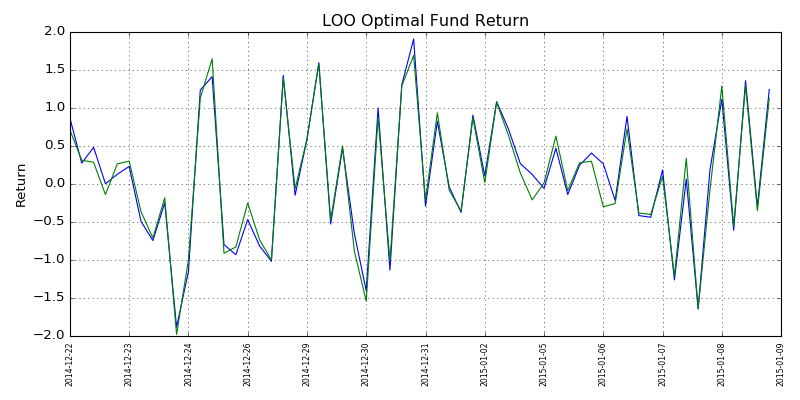

In [121]:
plt.close("all")


# plt.figure()
# plt.subplot(2,1,1)
# plt.title('Predicted R2 for different lambda ')
# ax = plt.gca()
# ax.grid()
# ax.set_xscale('log')
# ax.set_ylabel('R2')
# plt.plot(lam_arr,r2_lam_arr)


# plt.subplot(2,1,2)
# plt.title('Predicted R2 for different lambda at each time point')
# for t in range(1,T-1):
#     r2_t = r2_lam_t[:,t]
#     plt.plot(lam_arr,r2_t)
# ax = plt.gca()
# ax.grid()
# ax.set_ylabel('R2')
# ax.set_xscale('log')    



# # pyplot.matshow(r2_lam_t)


# argminlam  = lam_arr[np.argmin(r2_lam_arr)]

beta_opt_lam, fund_est = nsr.nonstatRegress(assets,fund, argminlam, outPoint,dynamic_model)
# plt.figure(figsize=(10,5))
# title = 'Optimal betas by lam = ' + str(argminlam) 
# plt.title(title)
# for i in range(0,n):
#     plt.plot(time, beta_opt_lam[:,i])
# plt.xticks(time, dates, rotation=90, size = 7)
# ax = plt.gca()
# ax.grid()
# ax.set_ylabel('Betas')
# ax.get_xaxis().set_tick_params(pad=5)
# ax.get_xaxis().set_major_locator(majorLocator)  
# plt.show()

# Plot  return
plt.figure(figsize=(10,5))
plt.title('LOO Optimal Fund Return')
plt.xticks(time, dates, rotation=90, size = 7)
ax = plt.gca()
ax.grid()
ax.set_ylabel('Return')
ax.get_xaxis().set_tick_params(pad=5)
ax.get_xaxis().set_major_locator(majorLocator)
plt.plot(time, fund, label = 'source')
plt.plot(time, fund_est, label = 'estimated')
plt.tight_layout() 

plt.show()

Eigenvalues and LOO

<IPython.core.display.Javascript object>


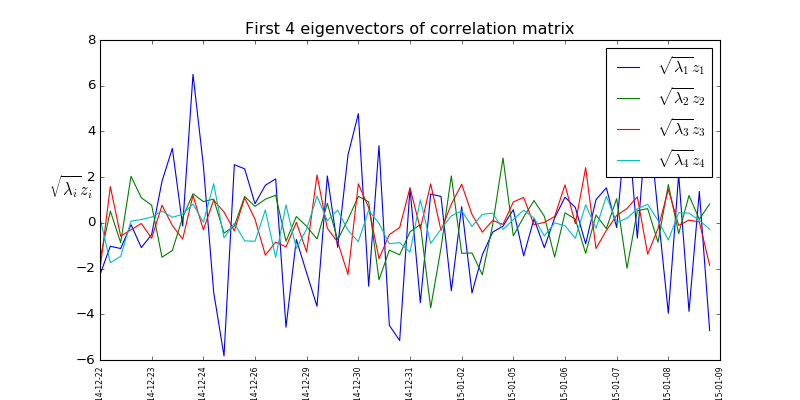

In [55]:
assetss  = assetsall[:,np.array([1,2,3,4,5,6,7,8,9,10,11])] 

n = np.size(assetss,1)
T = np.size(assetss,0)
M  = np.zeros([T,T])
for i in range(0,n):
    M = M + assetss[:,i] * assetss[:,i].T
#print(XXT)
eigvals, eigenvec = np.linalg.eig(M.astype("float64"))

ind = np.argsort(eigvals,)
ind = ind[::-1]
eigenvec = eigenvec[:, ind]
eigvals = eigvals[ind]
eigvals = eigvals.real
eigenvec =eigenvec.real

m=4

assets_ort = eigenvec[:,range(0,m)]
time =  range(T)
outPoint = np.zeros([T,1])
fund = fundsall[:,fnum]

n = np.size(assets_ort,1)
T = np.size(assets_ort,0)


fig = plt.figure(figsize=(10,5)) 
plt.title('First 4 eigenvectors of correlation matrix')
plt.xticks(time, dates, rotation=90, size = 7)
ax = plt.gca()
ax.set_ylabel(r'$\sqrt{\lambda_i} z_i$', fontsize=15, rotation=0)
ax.get_xaxis().set_tick_params(pad=5)

ax.get_xaxis().set_major_locator(majorLocator)

#plt.subplot(3,1,1)
for i in range(0,n):
    plt.plot(time, math.sqrt(eigvals[i])*assets_ort[:,i], label=(r'$\sqrt{\lambda_'+str(i+1)+'}z_'+str(i+1)+r"$"))
plt.legend()
fig.savefig('pic/'+'eigvecs'+'.png', dpi=200)
plt.show()

In [5]:
from matplotlib.ticker import MultipleLocator
majorLocator = MultipleLocator(5)

assetss  = assetsall[:,np.array([1,2,3,4,5,6,7,8,9,10,11])] 

n = np.size(assetss,1)
T = np.size(assetss,0)
X  = np.zeros([T,T])
for i in range(0,n):
    X = X + assetss[:,i] * assetss[:,i].T
#print(XXT)
eigvals, eigenvec = np.linalg.eig(X.astype("float64"))

ind = np.argsort(eigvals,)
ind = ind[::-1]
eigenvec = eigenvec[:, ind]
eigvals = eigvals[ind]
eigenvec =eigenvec.real

time =  range(T)
outPoint = np.zeros([T,1])
fund = fundsall[:,fnum]


LOO_eig_min_r2 = []
for fnum in range(10):
    lam_arr = []
    lam = 0.1
    while lam <=500:
        lam = lam*2
        lam_arr.append(lam)
        
    fund = fundsall[:,fnum]
    m_max = 11
    r2_min = 1000
    m_min  = 0
    lam_min = 0
    r2_lam_arr = np.zeros([m_max,len(lam_arr)])

#     plt.close("all")

#     plt.figure()
#     plt.title('Predicted R2 for different lambda ')
#     ax = plt.gca()
#     ax.set_xscale('log')

    for m in range(0,m_max):
            assets_ort = eigenvec[:,range(0,m+1)]
            n = np.size(assets_ort,1)
            T = np.size(assets_ort,0)       

            ilam = 0

            for lam in lam_arr:
                 r2_arr, r2_lam, fund_out = nsr.LeaveOneOut(assets_ort,fund,lam,dynamic_model)
                 r2_lam_arr[m,ilam] = r2_lam 
                 ilam = ilam+1
                 if r2_lam <= r2_min:           
                    r2_min = r2_lam
                    m_min = m
                    lam_min  = lam
            if m == 0: 
              series_labl =  str(m+1) + ' factor'
            else:
              series_labl =  str(m+1) + ' factors'  
            #plt.plot(lam_arr,r2_lam_arr[m,:], label = series_labl)
    LOO_eig_min_r2 += [(r2_min,lam_min, m_min)]
    #box = ax.get_position()

    #ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


    #plt.show()

In [6]:
LOO_eig_min_r2

[(0.032567580941296935, 6.4, 7),
 (0.089635624126153876, 819.2, 5),
 (0.014157036548683204, 25.6, 7),
 (0.087763931814024698, 819.2, 9),
 (0.047617258268062256, 3.2, 10),
 (0.020231288843388987, 819.2, 8),
 (0.0051376874727834289, 25.6, 10),
 (0.013644990388033049, 819.2, 8),
 (0.007718975099142494, 3.2, 10),
 (0.001445997692423189, 102.4, 8)]

In [9]:
lam_cross = []
lam = 0.1
while lam <=500:
    lam = lam*2
    lam_cross.append(lam)
    
lam_aic = []
lam = 0.01
while lam <=5000:
    lam = lam*5
    lam_aic.append(lam)

In [10]:
print [lam_cross[x[-1]] for x in LOO_eig_min_r2], [x[0] for x in LOO_eig_min_r2]
print [lam_aic[x[1]] for x in AIC_min_r2], [x[0] for x in AIC_min_r2]

[25.6, 6.4, 25.6, 102.4, 204.8, 51.2, 204.8, 51.2, 204.8, 51.2] [0.032567580941296935, 0.089635624126153876, 0.014157036548683204, 0.087763931814024698, 0.047617258268062256, 0.020231288843388987, 0.0051376874727834289, 0.013644990388033049, 0.007718975099142494, 0.001445997692423189]


NameError: name 'AIC_min_r2' is not defined

In [11]:
[lam_cross[x[1]] for x in LHO_min_r2], [x[0] for x in lHO_min_r2]

NameError: name 'LHO_min_r2' is not defined

In [119]:
lam_min =6.4

9 6.4 1000


<IPython.core.display.Javascript object>


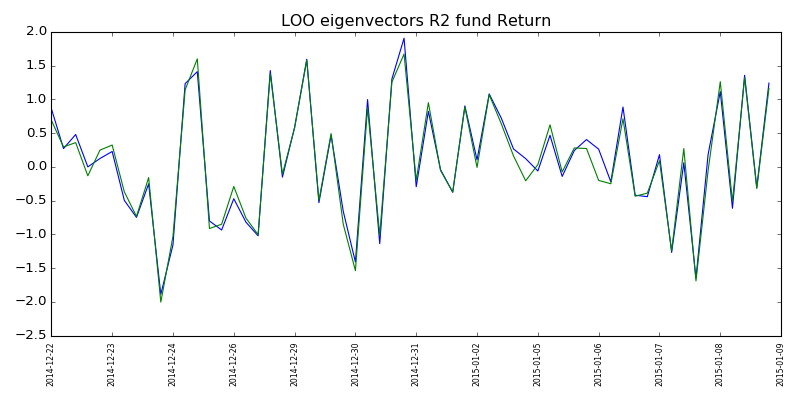

In [115]:
print m_min+1, lam_min, r2_min

assets_ort = eigenvec[:,range(0,m_min+1)]
beta_opt_lam, fund_est = nsr.nonstatRegress(assets_ort,fund, lam_min, outPoint,dynamic_model)
# plt.figure(figsize=(10,5))
# title = 'Optimal betas by lam = ' + str(lam_min) + ' and factor number ' + str(m_min+1) 
# plt.title(title)
# for i in range(0,m_min+1):
#     plt.plot(time, beta_opt_lam[:,i])
# plt.xticks(time, dates, rotation=90, size = 7)
# ax = plt.gca()
# ax.get_xaxis().set_tick_params(pad=5)
# ax.get_xaxis().set_major_locator(majorLocator)  
# plt.show()
plt.close('all')
# Plot  return
plt.figure(figsize=(10,5))
plt.title('LOO eigenvectors R2 fund Return')
plt.xticks(time, dates, rotation=90, size = 7)
ax = plt.gca()
ax.get_xaxis().set_tick_params(pad=5)
ax.get_xaxis().set_major_locator(majorLocator)
plt.plot(time, fund)
plt.plot(time, fund_est)
plt.tight_layout() 

plt.show()

### Turn Over

In [381]:
def turn_over(beta):
    return np.sum(np.abs(beta[1:] - beta[:-1]))

LeaveHalfOut

In [382]:
fnum = 7; T = N; time =  range(T)


In [328]:
from matplotlib.ticker import MultipleLocator
majorLocator = MultipleLocator(5)
outPoint = np.zeros([T,1])
dynamic_model = 0

assets = assetsall
lam_arr = []
lam = 0.01
while lam <=5000:
    lam = lam*2
    lam_arr.append(lam)
band = 10
LHO_min_r2 = []
r2_lam_arr_fund = []
for fn in range(fnum):
    fund = fundsall[:,fn]
    r2_lam_arr = []

    r2_lam_t = np.zeros([len(lam_arr),T]) 
    ilam = 0
    for lam in lam_arr:
         r2_arr, r2_lam, fund_out = nsr.LeaveHalfOut(assets,fund,lam,dynamic_model)
         r2_lam_t[ilam,:] = r2_arr.T    
         r2_lam_arr.append(r2_lam)
         ilam = ilam+1
    LHO_min_r2 += [(np.min(r2_lam_arr),np.argmin(r2_lam_arr))]
    r2_lam_arr_fund += [r2_lam_arr]
#print  r2_lam_arr   

In [316]:
lam_arr

[0.2,
 0.4,
 0.8,
 1.6,
 3.2,
 6.4,
 12.8,
 25.6,
 51.2,
 102.4,
 204.8,
 409.6,
 819.2,
 1638.4,
 3276.8,
 6553.6]

In [345]:
[np.argmin(r2_lam_arr_fund[fn]) for fn in range(7)]

[4, 13, 15, 13, 6, 6, 14]

In [346]:
LHO_min_r2

[(1.1288536439955344e-05, 4),
 (0.79983175343613266, 13),
 (0.38070871783751753, 15),
 (0.13690316657684221, 13),
 (0.11370541335650479, 6),
 (0.13415127324614848, 6),
 (0.33468714869090527, 14)]

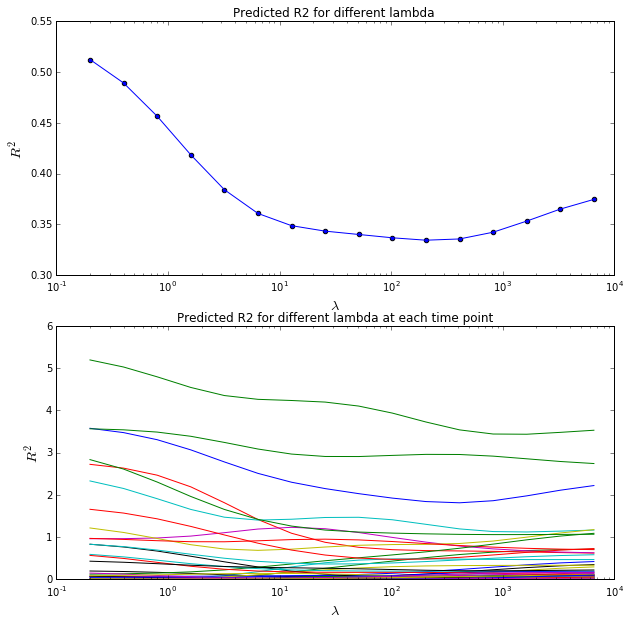

In [327]:
plt.figure()

plt.subplot(2,1,1)
plt.title('Predicted R2 for different lambda ')
ax = plt.gca()
ax.set_xscale('log')
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$R^2$")
plt.scatter(lam_arr,r2_lam_arr)
plt.plot(lam_arr,r2_lam_arr)

plt.subplot(2,1,2)
plt.title('Predicted R2 for different lambda at each time point')
for t in range(1,T-1):
    r2_t = r2_lam_t[:,t]
    plt.plot(lam_arr,r2_t)
ax = plt.gca()
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$R^2$")
ax.set_xscale('log')    


#pyplot.matshow(r2_lam_t)

Fund number:  1
28.351942432 15.8794163705
176.0


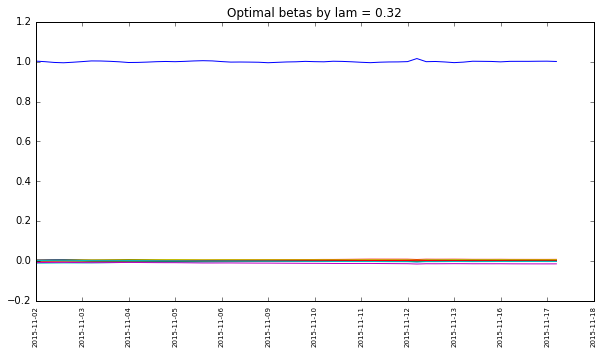

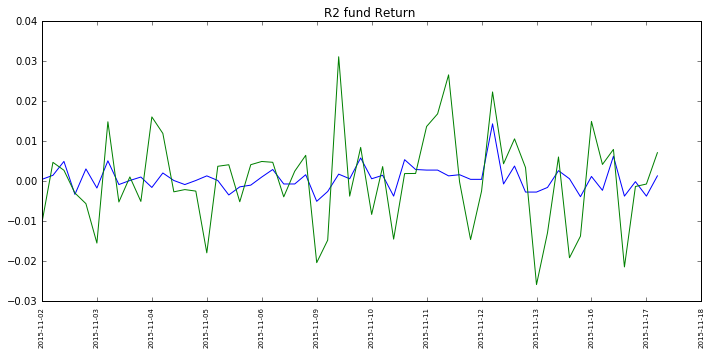

Fund number:  2
555.474384601 293.752841379
75.0


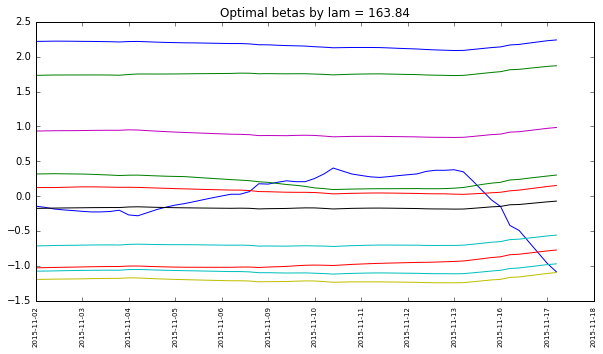

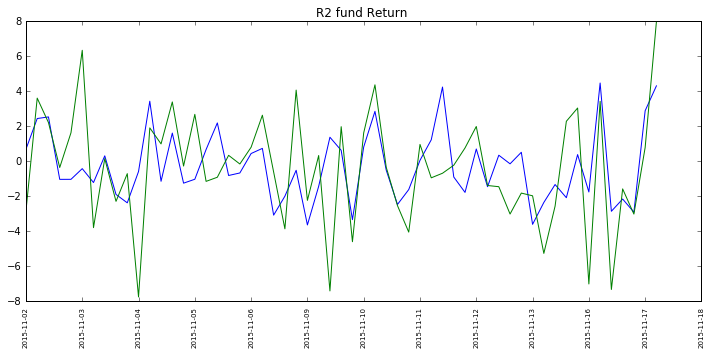

Fund number:  3
125.355041692 65.3159264952
101.0


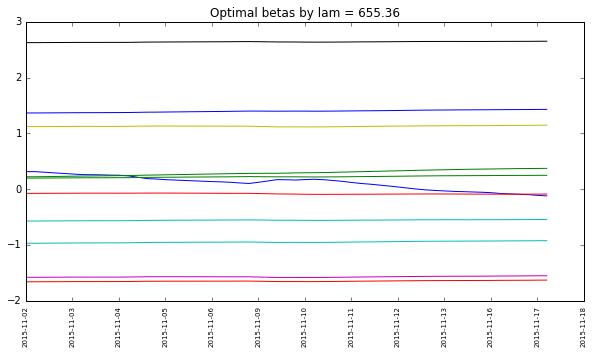

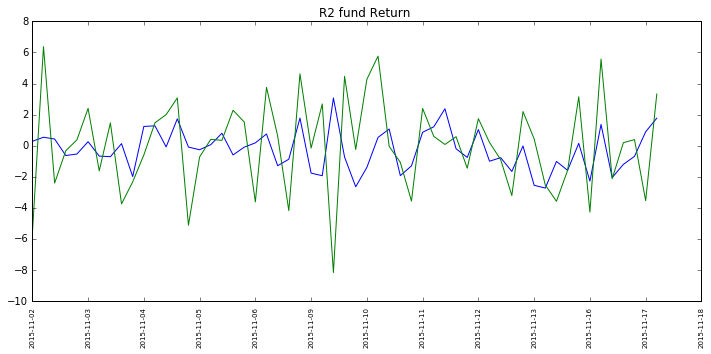

Fund number:  4
180.250675167 96.4523686749
59.0


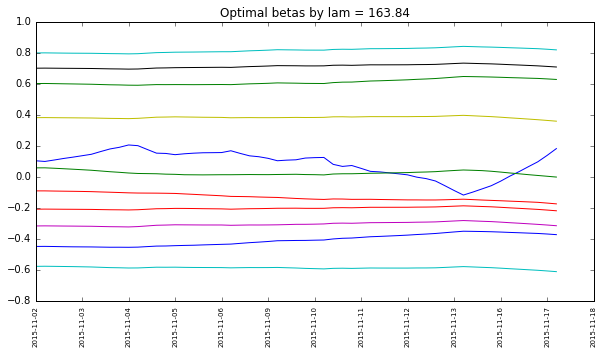

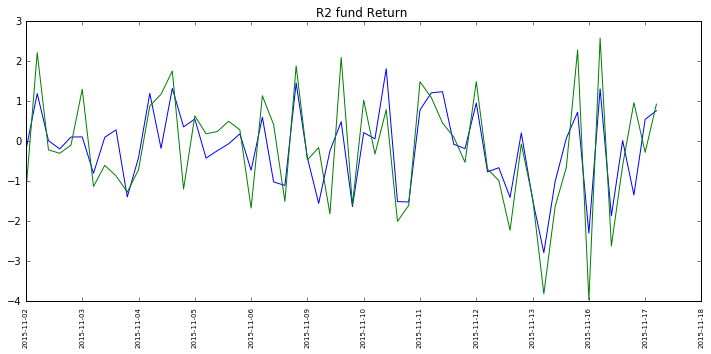

Fund number:  5
1978.98700921 1233.94786854
74.0


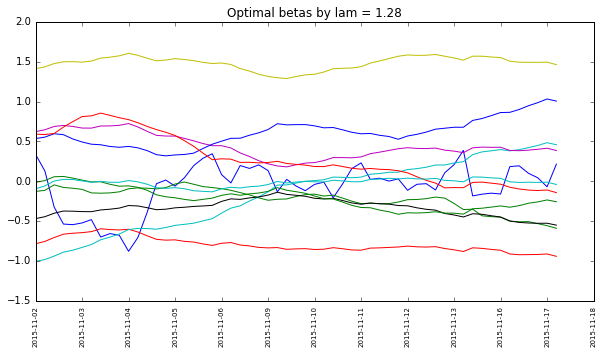

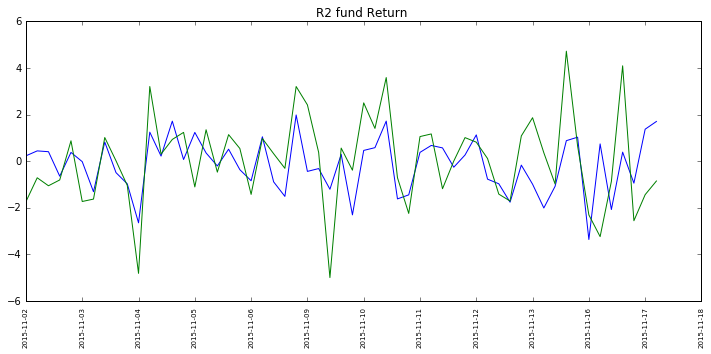

Fund number:  6
2212.0786748 1317.77927618
348.0


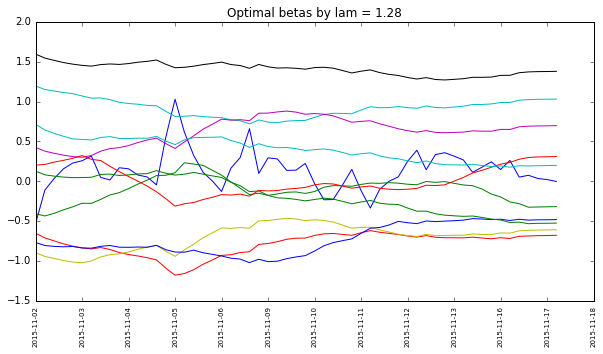

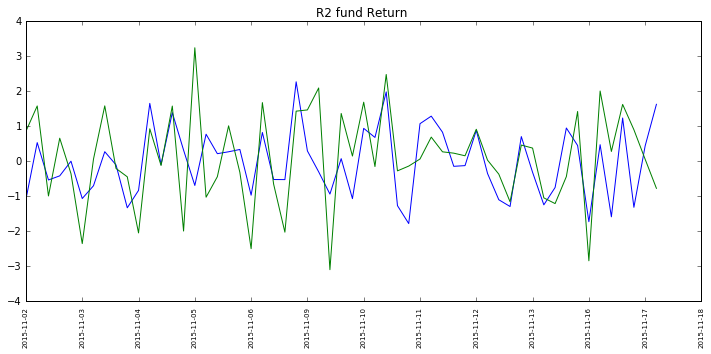

Fund number:  7
147.548475297 78.5189100058
56.0


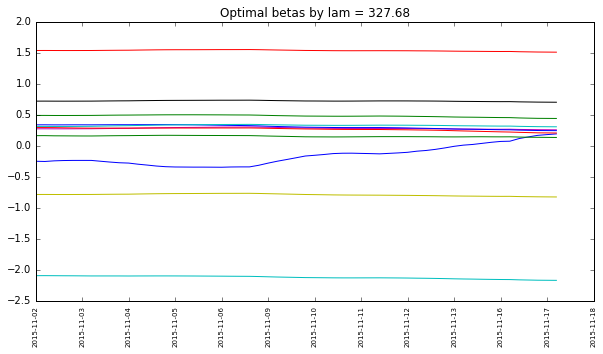

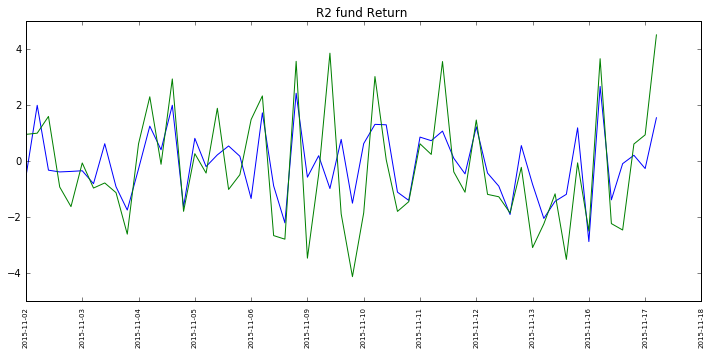

In [395]:
for fn in range(fnum):
    lam_min = lam_arr[LHO_min_r2[fn][1]]
    fund = fundsall[:,fn]
    assets = assetsall
    beta_opt_lam, fund_est = nsr.nonstatRegress(assets,fund, lam_min, outPoint,dynamic_model)
    beta_opt_lam = np.hstack((1 - np.sum(beta_opt_lam, axis=1).reshape(-1, 1), beta_opt_lam))
    fund_est = np.array([np.sum(raw_assets[t, :] * beta_opt_lam[t, :]) for t in range(N)])
    print("Fund number: ", fn+1)
    print(turn_over(beta_opt_lam)*100, turn_over(beta_opt_lam[:,1:])*100)
    print(turn_overs[fn])
    #print(beta_opt_lam[:, 0])
    
    plt.figure(figsize=(10,5))
    title = 'Optimal betas by lam = ' + str(lam_min)
    plt.title(title)
    plt.plot(time, beta_opt_lam)
    plt.xticks(time, dates, rotation=90, size = 7)
    ax = plt.gca()
    ax.get_xaxis().set_tick_params(pad=5)
    ax.get_xaxis().set_major_locator(majorLocator)  
    plt.show()

    # Plot  return
    plt.figure(figsize=(10,5))
    plt.title('R2 fund Return ')
    plt.xticks(time, dates, rotation=90, size = 7)
    ax = plt.gca()
    ax.get_xaxis().set_tick_params(pad=5)
    ax.get_xaxis().set_major_locator(majorLocator)
    plt.plot(time, fund)
    plt.plot(time, fund_est)
    plt.tight_layout() 

    plt.show()

AIC

In [358]:
from matplotlib.ticker import MultipleLocator
majorLocator = MultipleLocator(5)


assets = assetsall
lam_arr = []
lam = 0.01
while lam <=5000:
    lam = lam*2
    lam_arr.append(lam)

AIC_min_r2 = []
aic_r2_lam_arr_fund = []
for fnum in range(len(evid_list_full)):
    fund = fundsall[:,fnum]
    r2_lam_arr = []
    tr_lam_arr = []
    arr = []
    for lam in lam_arr:
         r2_lam, trace_lam = nsr.AIC(assets,fund,lam,dynamic_model)
         r2_lam_arr.append(r2_lam*30)
         tr_lam_arr.append(trace_lam)
    new_r2_lam_arr = [x *T  for x in  r2_lam_arr]
    tr_lam_arr = [x for x in  tr_lam_arr]
    aic = [x +y  for x, y in zip(new_r2_lam_arr,tr_lam_arr)]

    AIC_min_r2 +=  [(np.min(aic), np.argmin(aic))]  
    aic_r2_lam_arr_fund += [aic]
#print  r2_lam_arr   
# plt.figure()
# plt.title('AIC ')
# ax = plt.gca()
# ax.set_xscale('log')
# new_r2_lam_arr = [x *T  for x in  r2_lam_arr]
# tr_lam_arr = [x for x in  tr_lam_arr]
# aic = [x +y  for x, y in zip(new_r2_lam_arr,tr_lam_arr)]
# plt.plot(lam_arr,new_r2_lam_arr, label='error')
# plt.plot(lam_arr,tr_lam_arr, label='delta')
# plt.plot(lam_arr,aic, label='AIC')
# box = ax.get_position()
# ax.set_position([box.x0, box.y0 + box.height * 0.1,
#                  box.width, box.height * 0.9])

# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=3)

In [367]:
lam_arr[AIC_min_r2[4][1]]

0.32

Fund number:  1
0.144545637965 0.0730302091964
176.0


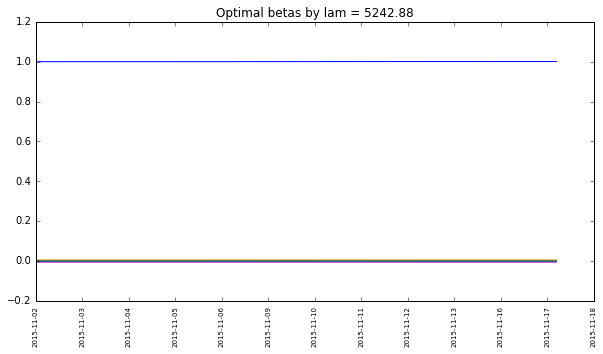

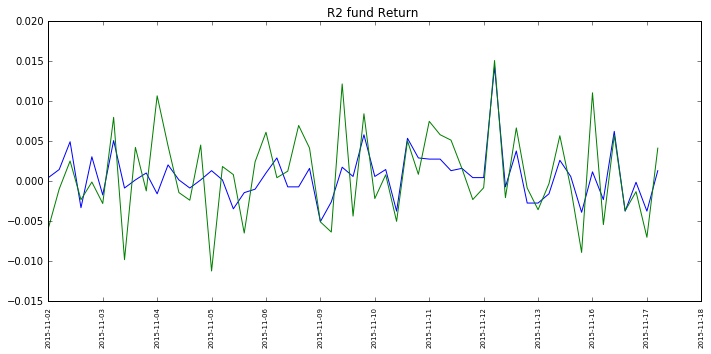

Fund number:  2
6682.70671856 4012.47868211
75.0


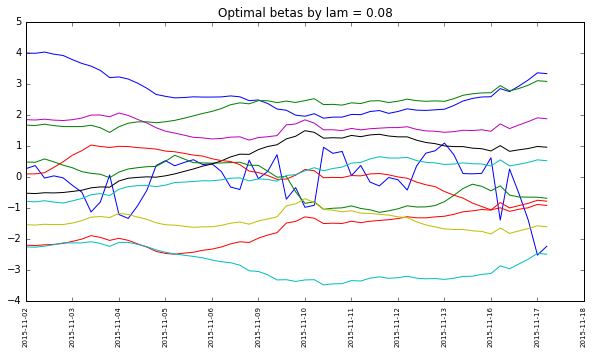

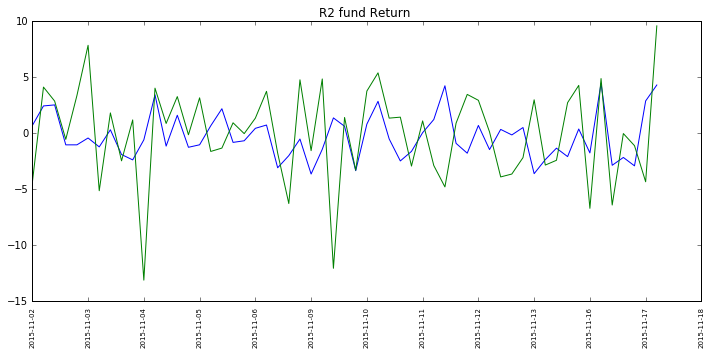

Fund number:  3
3399.1629703 1867.78913102
101.0


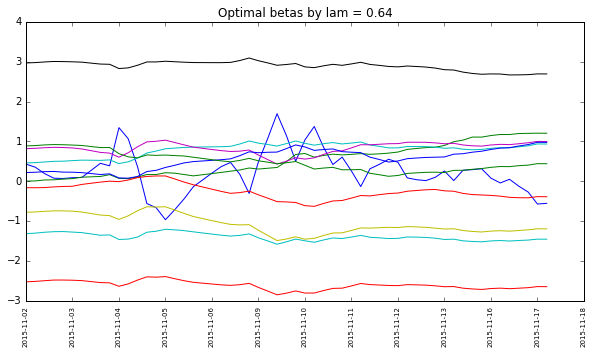

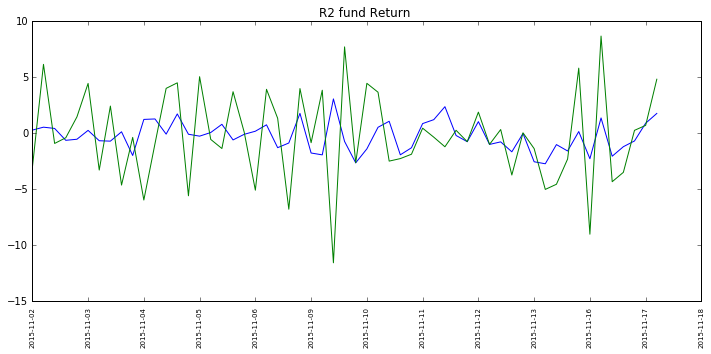

Fund number:  4
2259.22331643 1281.68688043
59.0


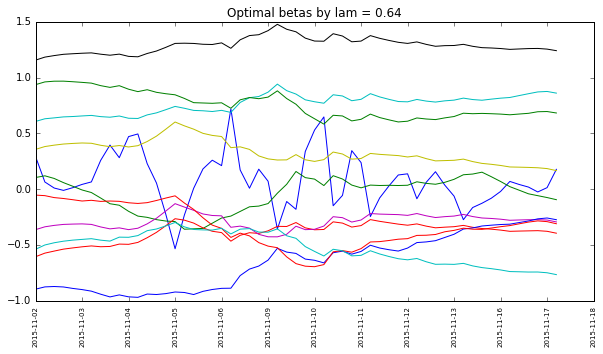

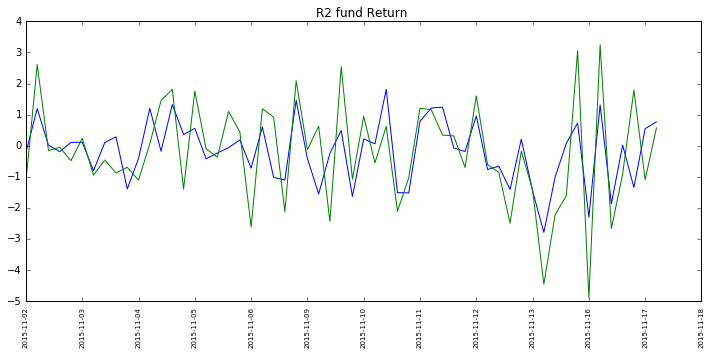

Fund number:  5
2577.55676079 1610.21944991
74.0


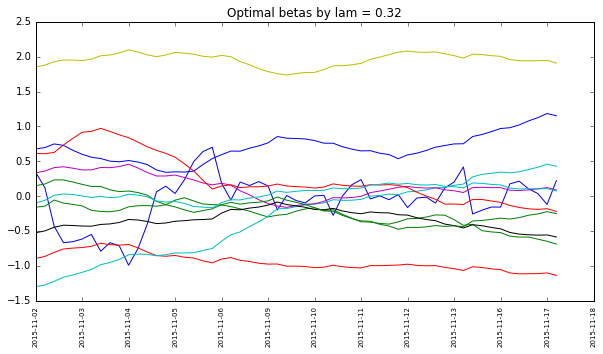

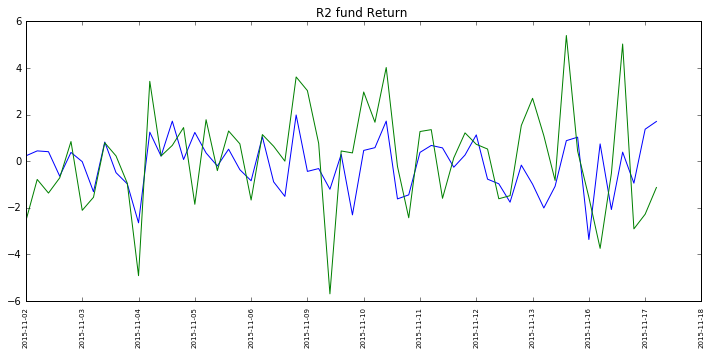

Fund number:  6
2522.12738684 1498.28173658
348.0


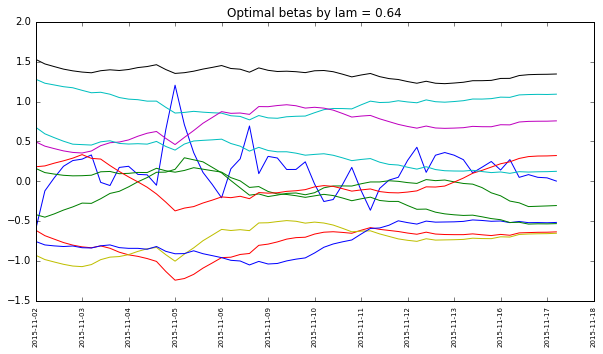

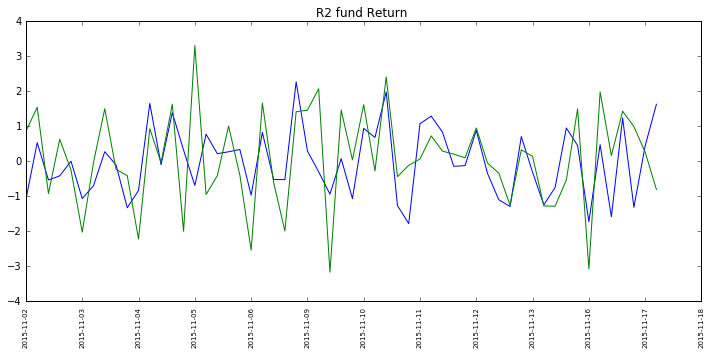

Fund number:  7
3645.94602457 2215.08584689
56.0


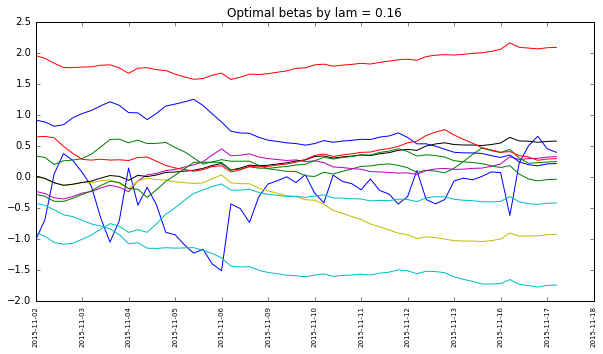

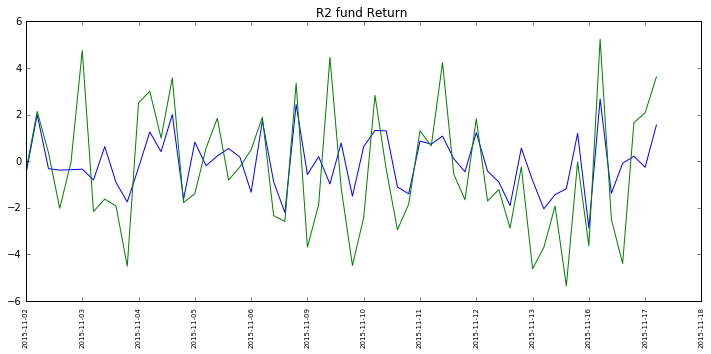

In [394]:
for fn in range(len(evid_list_full)):
    lam_min = lam_arr[AIC_min_r2[fn][1]]
    fund = fundsall[:,fn]
    assets = assetsall
    beta_opt_lam, fund_est = nsr.nonstatRegress(assets,fund, lam_min, outPoint,dynamic_model)
    beta_opt_lam = np.hstack((1 - np.sum(beta_opt_lam, axis=1).reshape(-1, 1), beta_opt_lam))
    fund_est = np.array([np.sum(raw_assets[t, :] * beta_opt_lam[t, :]) for t in range(N)])
    print("Fund number: ", fn+1)
    print(turn_over(beta_opt_lam)*100, turn_over(beta_opt_lam[:,1:])*100)
    print(turn_overs[fn])
    #print(beta_opt_lam[:, 0])
    
    plt.figure(figsize=(10,5))
    title = 'Optimal betas by lam = ' + str(lam_min)
    plt.title(title)
    plt.plot(time, beta_opt_lam)
    plt.xticks(time, dates, rotation=90, size = 7)
    ax = plt.gca()
    ax.get_xaxis().set_tick_params(pad=5)
    ax.get_xaxis().set_major_locator(majorLocator)  
    plt.show()

    # Plot  return
    plt.figure(figsize=(10,5))
    plt.title('R2 fund Return ')
    plt.xticks(time, dates, rotation=90, size = 7)
    ax = plt.gca()
    ax.get_xaxis().set_tick_params(pad=5)
    ax.get_xaxis().set_major_locator(majorLocator)
    plt.plot(time, fund)
    plt.plot(time, fund_est)
    plt.tight_layout() 

    plt.show()

### Evidence

In [379]:
[(lam_list_full[fn][-1], delta_list_full[fn][-1]) for fn in range(7)]

[(21063.879535846394, 2.7922560637848375),
 (237.80877179369446, 81.119859886025552),
 (42889.085704657147, 72.471524090983181),
 (24418.129824422391, 56.375306251946512),
 (368.26854481074912, 65.726845221276164),
 (10874.210167845475, 107.96270995781438),
 (20478.147467904542, 25.148228547298263)]

Fund number:  1
0.0179432333405 0.00902120515297
176.0


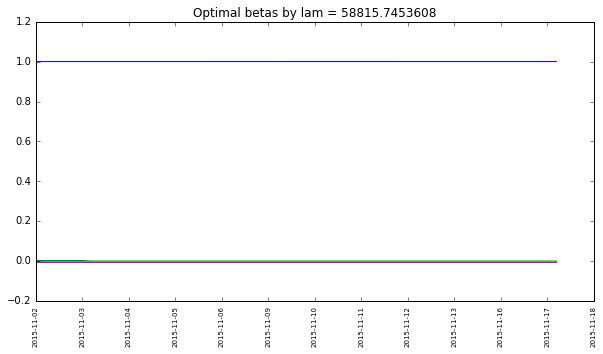

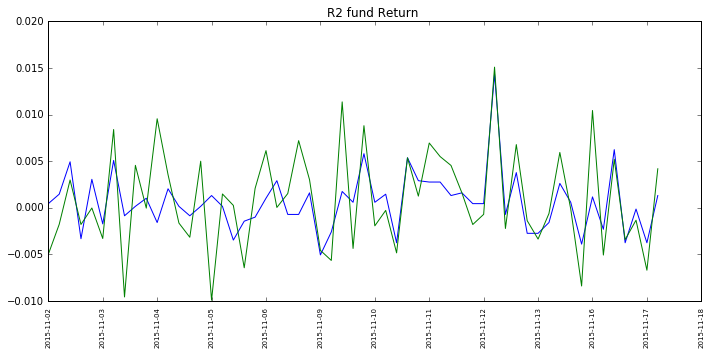

Fund number:  2
14.4223514721 7.27936233402
75.0


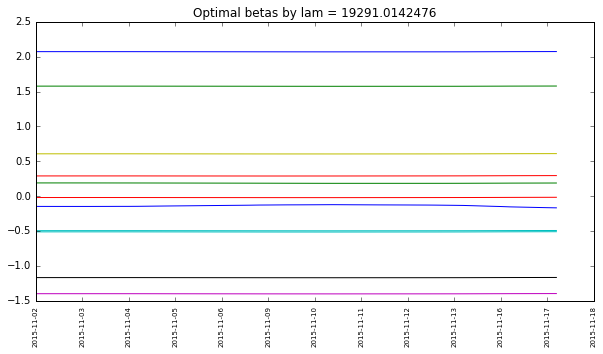

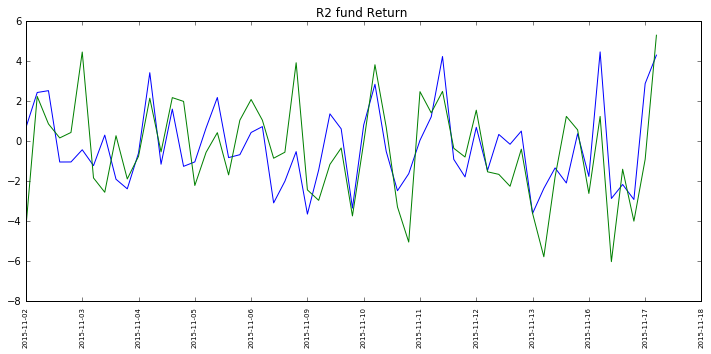

Fund number:  3
0.0772581269899 0.0388144088735
101.0


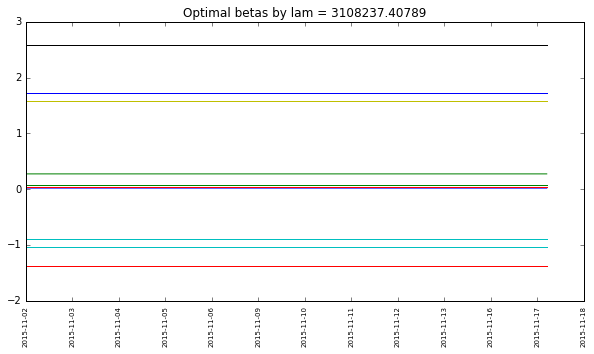

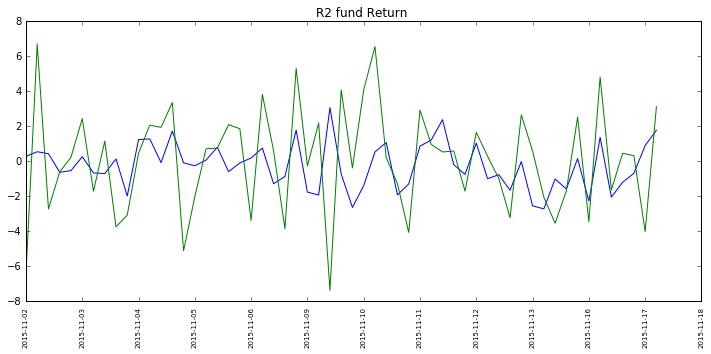

Fund number:  4
0.0976366721527 0.0490990125929
59.0


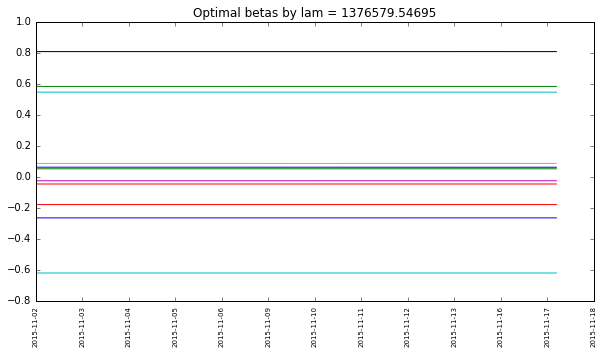

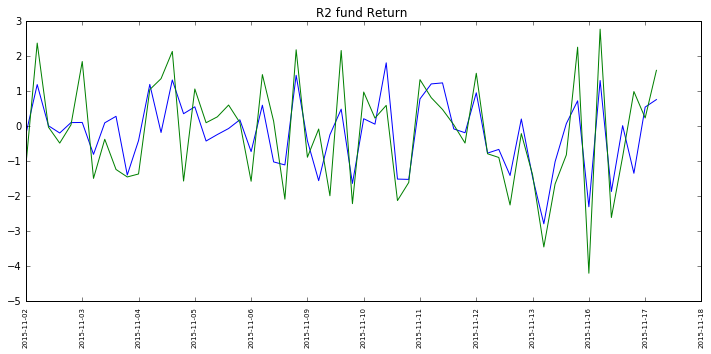

Fund number:  5
2.89376052016 1.47429013763
74.0


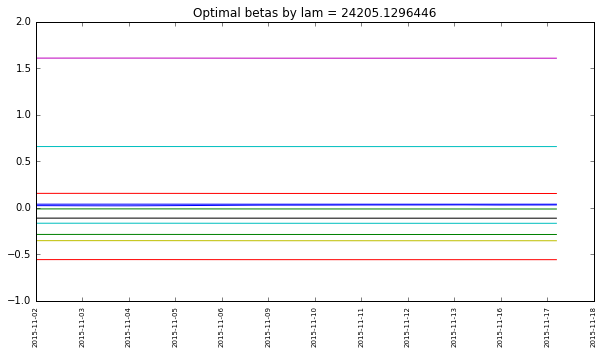

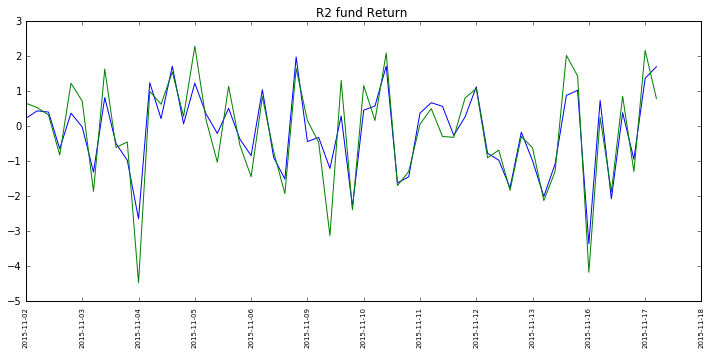

Fund number:  6
0.0576382864494 0.0307147359053
348.0


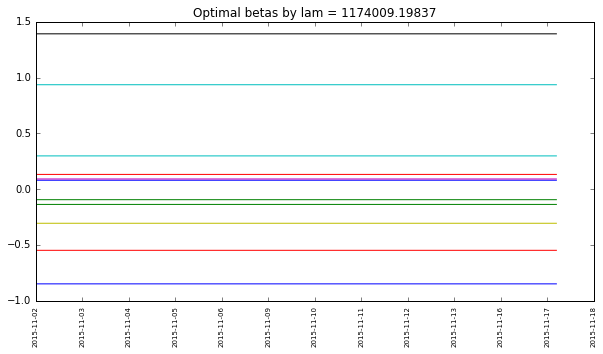

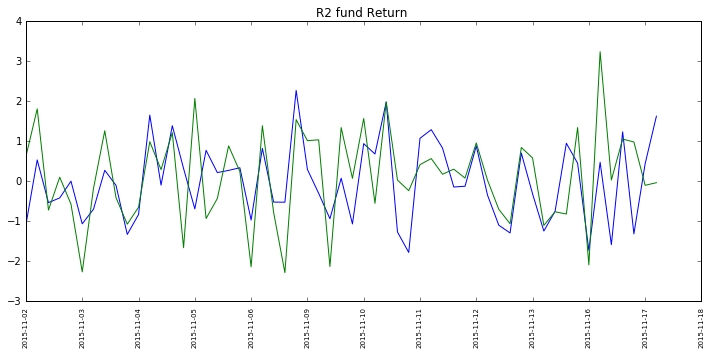

Fund number:  7
0.496706730926 0.249806035956
56.0


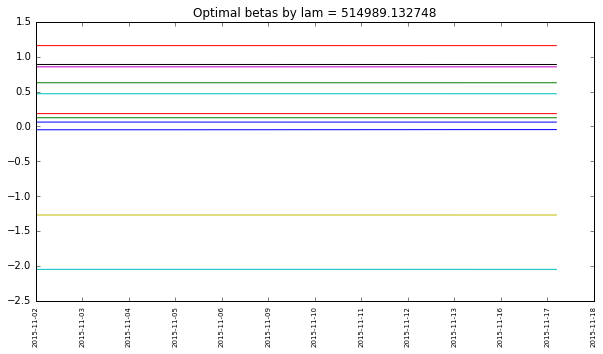

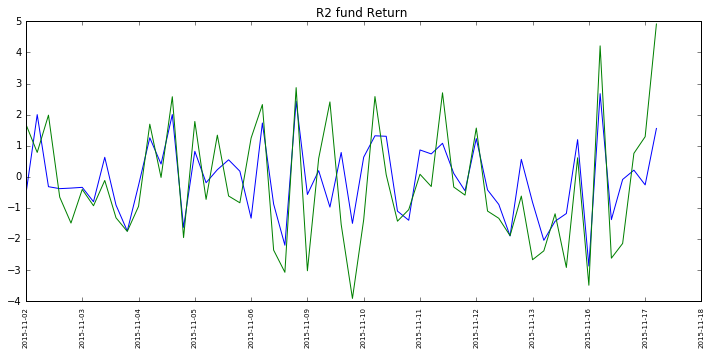

In [393]:
for fn in range(len(evid_list_full)):
    lam_min = lam_list_full[fn][-1]*delta_list_full[fn][-1]
    fund = fundsall[:,fn]
    assets = assetsall
    beta_opt_lam, fund_est = nsr.nonstatRegress(assets,fund, lam_min, outPoint,dynamic_model)
    beta_opt_lam = np.hstack((1 - np.sum(beta_opt_lam, axis=1).reshape(-1, 1), beta_opt_lam))
    fund_est = np.array([np.sum(raw_assets[t, :] * beta_opt_lam[t, :]) for t in range(N)])
    print("Fund number: ", fn+1)
    print(turn_over(beta_opt_lam)*100, turn_over(beta_opt_lam[:,1:])*100)
    print(turn_overs[fn])
    #print(beta_opt_lam[:, 0])
    
    plt.figure(figsize=(10,5))
    title = 'Optimal betas by lam = ' + str(lam_min)
    plt.title(title)
    plt.plot(time, beta_opt_lam)
    plt.xticks(time, dates, rotation=90, size = 7)
    ax = plt.gca()
    ax.get_xaxis().set_tick_params(pad=5)
    ax.get_xaxis().set_major_locator(majorLocator)  
    plt.show()

    # Plot  return
    plt.figure(figsize=(10,5))
    plt.title('R2 fund Return ')
    plt.xticks(time, dates, rotation=90, size = 7)
    ax = plt.gca()
    ax.get_xaxis().set_tick_params(pad=5)
    ax.get_xaxis().set_major_locator(majorLocator)
    plt.plot(time, fund)
    plt.plot(time, fund_est)
    plt.tight_layout() 

    plt.show()

In [389]:
%store AIC_min_r2

Stored 'AIC_min_r2' (list)


In [390]:
%store LHO_min_r2

Stored 'LHO_min_r2' (list)
